In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../Code')
from utils import save_adata, read_adata

import palettable
from IPython.display import display

from joblib import parallel_backend
from scipy.stats import ranksums
from harmony import harmonize
from statsmodels.stats.multitest import multipletests

import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from geneset_testing import load_geneset

sys.path.append('../../../code/Code/klunctions/sam/Analysis/scBasics')
import helper_functions as hf
import scrublet as scr


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

gcs=False

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
results_dir = '../../../results'


## load data

In [3]:
E, barcodes, gene_list = hf.load_cellranger_h5_v2('../../../data/HCA_BoneMarrow/ica_bone_marrow_h5.h5', 'GRCh38')

In [4]:
samp_id_flat = np.array([b.split('_')[0] for b in barcodes])

sample_name = np.sort(np.unique(samp_id_flat))
print(sample_name)

['MantonBM1' 'MantonBM2' 'MantonBM3' 'MantonBM4' 'MantonBM5' 'MantonBM6'
 'MantonBM7' 'MantonBM8']


## separate by donor

In [5]:
D = {}
min_tot_default = 300
max_mt_default = 0.1

for s in sample_name:
    D[s] = {}
    
    mask = samp_id_flat == s
    D[s]['E'] = E[mask, :]
    D[s]['obs'] = pd.DataFrame({'sample': [s for i in range(mask.sum())]})
    D[s]['uns'] = {'min_tot': min_tot_default, 'max_mt': max_mt_default}
    D[s]['obsm'] = {}
    
    print(s, mask.sum())
    
    

MantonBM1 48000
MantonBM2 48000
MantonBM3 48000
MantonBM4 48000
MantonBM5 48000
MantonBM6 42000
MantonBM7 48000
MantonBM8 48000


In [6]:
del E, barcodes

## filter by total counts to remove background

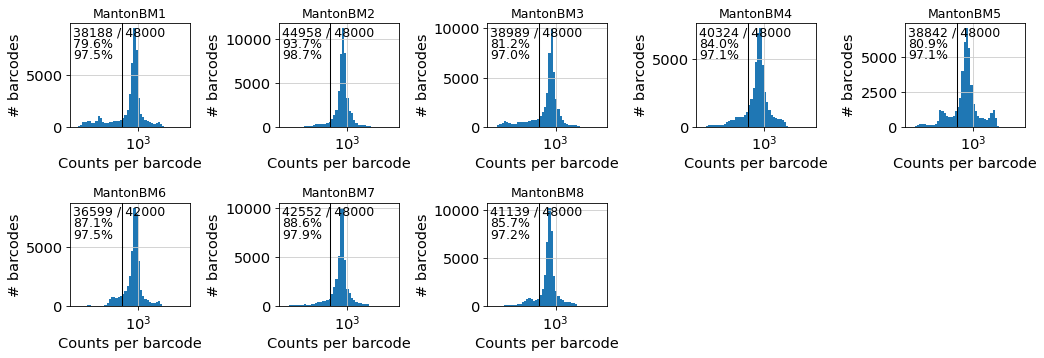

In [8]:
# Change total count thresholds based on the histograms. 
# If a library is not included below, the default threshold is used.
#D['MantonBM1']['uns']['min_tot'] = 300
#D['MantonBM2']['uns']['min_tot'] = 300
#D['MantonBM3']['uns']['min_tot'] = 300
#D['MantonBM4']['uns']['min_tot'] = 300
#D['MantonBM5']['uns']['min_tot'] = 300
#D['MantonBM6']['uns']['min_tot'] = 300
#D['MantonBM7']['uns']['min_tot'] = 300
#D['MantonBM8']['uns']['min_tot'] = 300


# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_name), row_height=2.5)

for iS,s in enumerate(sample_name):
    # Loop over each library, plotting histogram of total counts (UMIs) per cell
    
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)
    
    # Calculate total counts per cells (row sums of counts matrix)
    D[s]['obs']['total_counts'] = (D[s]['E']>0).sum(1).A.squeeze()
    
    # Get minimum total counts threshold. Barcodes with 
    # total counts >= min_tot are considered real cells. 
    min_tot = D[s]['uns']['min_tot']
    
    # Plot the histogram
    hf.total_counts_histogram(D[s]['obs']['total_counts'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=False)
    ax.set_title(s, fontsize=12)
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    
    # Plot the threshold    
    ax.plot(min_tot * np.ones(2), yl, c='black', linewidth=1)
    
    # Calculate number of barcodes passing filter and show on plot
    ntot = len(D[s]['obs']['total_counts'])
    npass = (D[s]['obs']['total_counts'] >= min_tot).sum()
    frac_umi_pass = D[s]['obs']['total_counts'].values[(D[s]['obs']['total_counts'] >= min_tot).values].sum() / D[s]['obs']['total_counts'].sum()
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.88, '{} / {}'.format(npass, ntot), fontsize=12)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.77, '{:.1f}%'.format(npass/ntot*100), fontsize=12)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.66, '{:.1f}%'.format(frac_umi_pass*100), fontsize=12)
    
fig.tight_layout()


In [9]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_name:
    keep = D[s]['obs']['total_counts'] >= D[s]['uns']['min_tot']
    D[s]['E'] = D[s]['E'][keep.values,:]
    D[s]['obs'] = D[s]['obs'][keep]
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))
    

Sample                  # barcodes pre-filter   # barcodes post-filter
MantonBM1                               48000                    38188
MantonBM2                               48000                    44958
MantonBM3                               48000                    38989
MantonBM4                               48000                    40324
MantonBM5                               48000                    38842
MantonBM6                               42000                    36599
MantonBM7                               48000                    42552
MantonBM8                               48000                    41139


## filter by mito-frac to remove dead cells

In [10]:
mt_ix = np.array([i for i,g in enumerate(gene_list) if g.startswith('MT-')], dtype=int)
print(gene_list[mt_ix])

['MT-ND1' 'MT-ND2' 'MT-CO1' 'MT-CO2' 'MT-ATP8' 'MT-ATP6' 'MT-CO3' 'MT-ND3'
 'MT-ND4L' 'MT-ND4' 'MT-ND5' 'MT-ND6' 'MT-CYB']


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


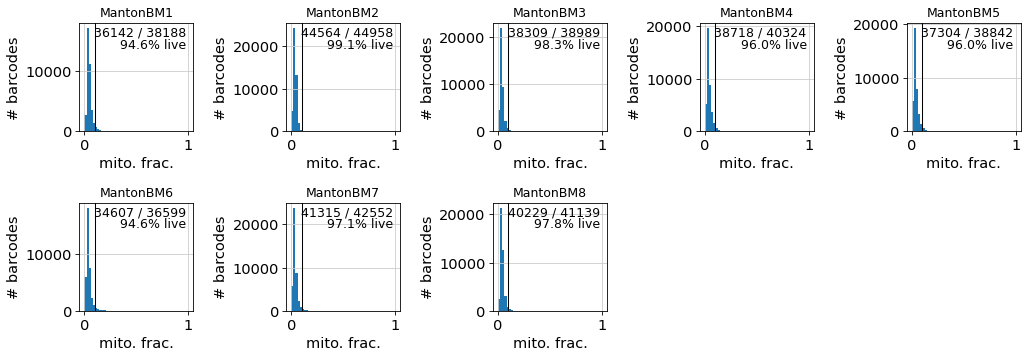

In [11]:
# Adjust threshold if desired
#D['MantonBM1']['uns']['max_mt'] = 0.1
#D['MantonBM2']['uns']['max_mt'] = 0.1
#D['MantonBM3']['uns']['max_mt'] = 0.1
#D['MantonBM4']['uns']['max_mt'] = 0.1
#D['MantonBM5']['uns']['max_mt'] = 0.1
#D['MantonBM6']['uns']['max_mt'] = 0.1
#D['MantonBM7']['uns']['max_mt'] = 0.1
#D['MantonBM8']['uns']['max_mt'] = 0.1

# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_name), row_height=2.5)

for iS,s in enumerate(sample_name):
    # Loop over each library, plotting histogram of fraction of UMIs
    # coming from mitochondrial genes.
    
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)

    # Calculate fraction of counts from mitochondrial  genes
    D[s]['obs']['mito_frac'] = D[s]['E'][:,mt_ix].sum(1).A.squeeze() / D[s]['E'].sum(1).A.squeeze()
    
    # Get maximum mitochondrial gene fraction. Barcodes with
    # mito fracs <= max_mt are considered live cells. 
    max_mt = D[s]['uns']['max_mt']
    
    # Plot the histogram
    ax.hist(D[s]['obs']['mito_frac'], np.linspace(0, 1, 50));
    ax.set_title(s, fontsize=12)
    ax.set_xlabel('mito. frac.')
    ax.set_ylabel('# barcodes')
    
    xl = np.array([0,1])
    yl = np.array(ax.get_ylim())
    ax.set_ylim(xl)
    ax.set_ylim(yl)
    
    # Plot the threshold    
    ax.plot(max_mt * np.ones(2), yl, c='black', linewidth=1)
    
    # Calculate number of barcodes passing filter and show on plot
    ntot = len(D[s]['obs']['mito_frac'])
    npass = (D[s]['obs']['mito_frac'] <= max_mt).sum()
    ax.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.88, '{} / {}'.format(npass, ntot), fontsize=12, ha='right')
    ax.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.77, '{:.1f}% live'.format(npass/ntot*100), fontsize=12, ha='right')
    
fig.tight_layout()

In [12]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_name:
    keep = D[s]['obs']['mito_frac'] <= D[s]['uns']['max_mt']
    D[s]['E'] = D[s]['E'][keep.values,:]
    D[s]['obs'] = D[s]['obs'][keep]
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))


Sample                  # barcodes pre-filter   # barcodes post-filter
MantonBM1                               38188                    36142
MantonBM2                               44958                    44564
MantonBM3                               38989                    38309
MantonBM4                               40324                    38718
MantonBM5                               38842                    37304
MantonBM6                               36599                    34607
MantonBM7                               42552                    41315
MantonBM8                               41139                    40229


## preprocess
(Scrublet, UMAP, clustering)

____________________
MantonBM1
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 47.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.8%
Elapsed time: 97.8 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..


____________________
MantonBM2
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 55.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.1%
Elapsed time: 125.3 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM3
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 39.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.7%
Elapsed time: 106.8 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM4
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 40.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.6%
Elapsed time: 108.0 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM5
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 37.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.0%
Elapsed time: 99.4 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM6
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 43.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.6%
Elapsed time: 87.7 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM7
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 46.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.4%
Elapsed time: 108.9 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


____________________
MantonBM8
Preprocessing...
Simulating doublets...
Embedding transcriptomes using Truncated SVD...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 39.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.6%
Elapsed time: 111.2 seconds
Running UMAP...


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is dep


All done!


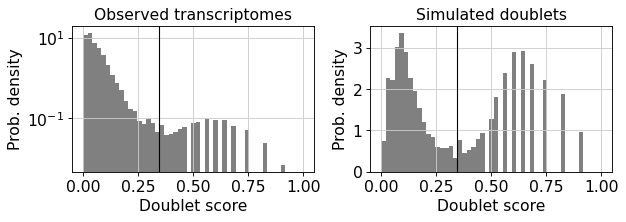

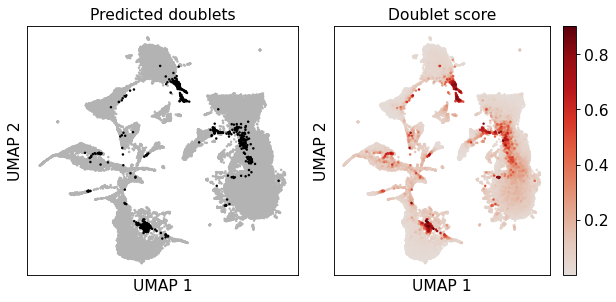

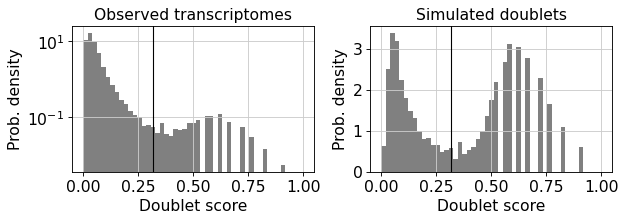

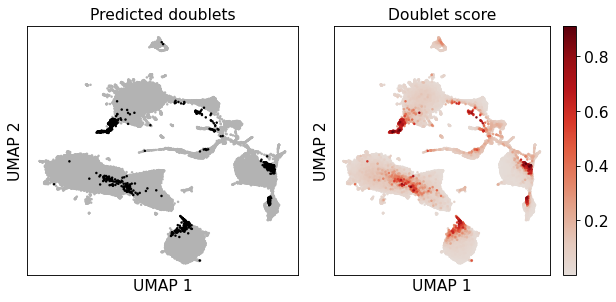

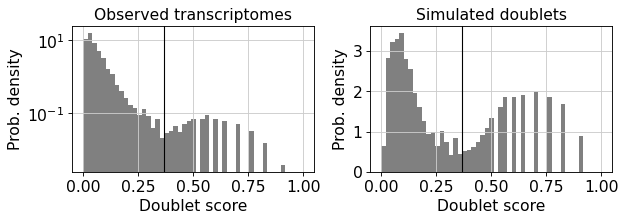

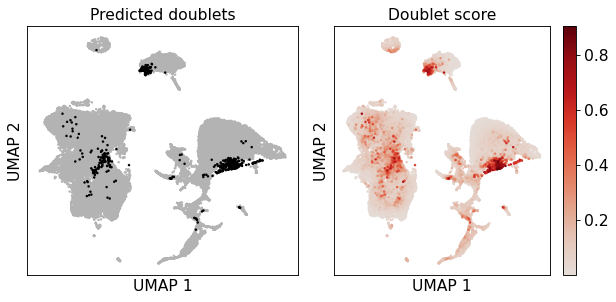

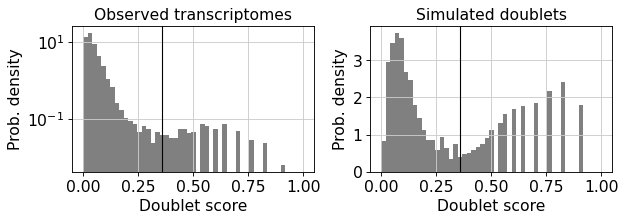

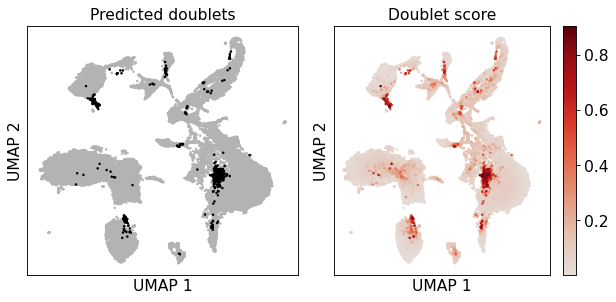

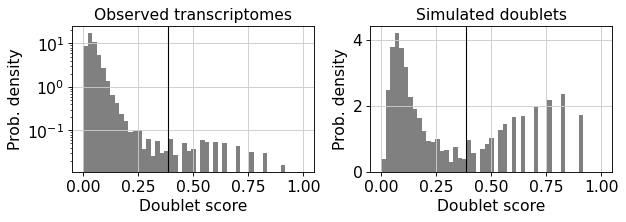

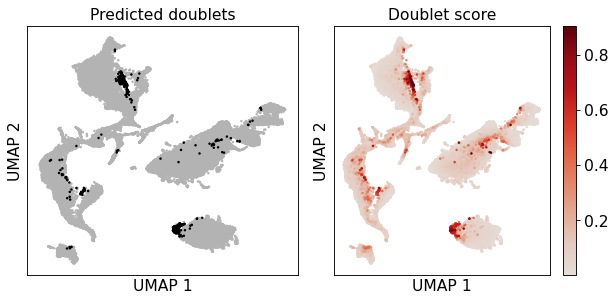

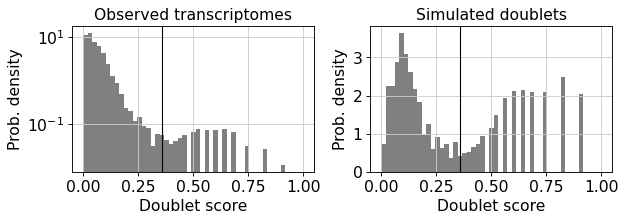

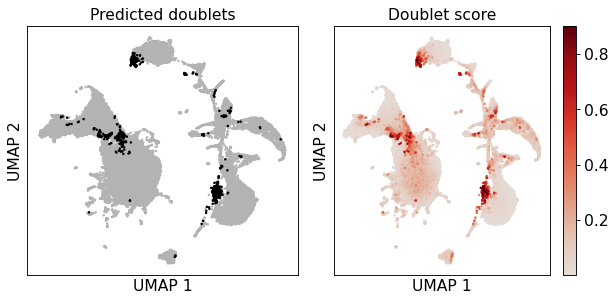

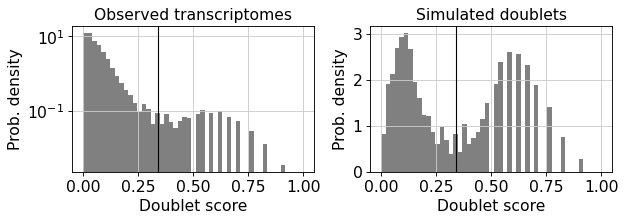

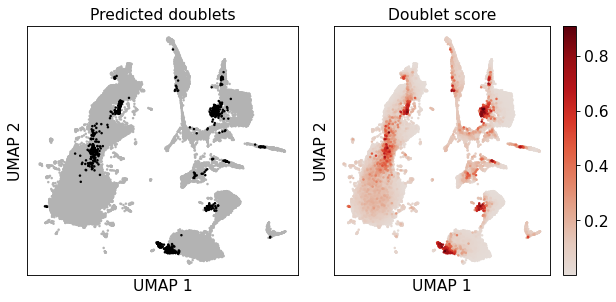

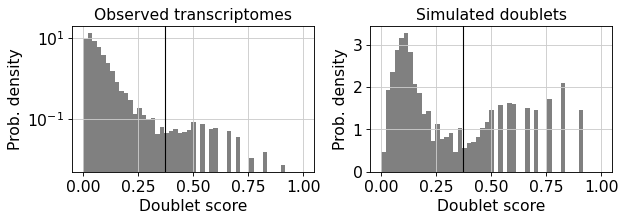

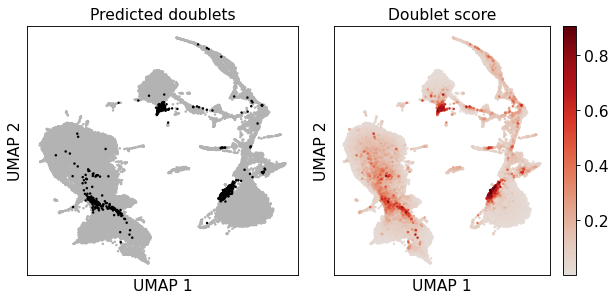

In [13]:
for s in sample_name:
    print("____________________")
    print(s)
    
    scrub = scr.Scrublet(D[s]['E'], expected_doublet_rate=0.06)
    D[s]['obs']['doublet_score'], D[s]['obs']['predicted_doublet'] = scrub.scrub_doublets(min_counts=2,
                                                                                   min_cells=5, 
                                                                                   min_gene_variability_pctl=85, 
                                                                                   n_prin_comps=60, 
                                                                                   mean_center=False, 
                                                                                   normalize_variance=True
                                                                                  )
    D[s]['uns']['gene_filter'] = scrub._gene_filter.copy()
    D[s]['obsm']['pca'] = scrub.manifold_obs_.copy()
    scrub.plot_histogram()
    
    print('Running UMAP...')
    D[s]['obsm']['umap'] = hf.get_umap(D[s]['obsm']['pca'], min_dist=0.3)
    
    scrub.set_embedding('UMAP', D[s]['obsm']['umap'])
    scrub.plot_embedding('UMAP', order_points=True)
    del scrub
    
    print()
    
print('All done!')
# del E_norm

In [14]:
D[s].keys()

dict_keys(['E', 'obs', 'uns', 'obsm'])

## Save

In [15]:
import pickle
save_dir = '../../../data/HCA_BoneMarrow/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for s in sample_name:
    pickle.dump(D[s], open(f'{save_dir}/workspace_190126_v2.{s}.pickle', 'wb'), -1)


# Load old preprocessed data
Scrublet has already been run, but no transcriptomes have been removed.  
It's an old format, so let's convert it to AnnData.

In [16]:

hca = {}

for s in sample_name:
    hca[s] = hf.load_pickle(f'{save_dir}/workspace_190126_v2.{s}.pickle')
    
    tmp = sc.AnnData(hca[s]['E'])
    for k in hca[s]['obs'].columns:
        tmp.obs[k] = hca[s]['obs'][k].values
    tmp.obsm['X_pca'] = hca[s]['obsm']['pca'].copy()
    tmp.obsm['X_umap'] = hca[s]['obsm']['umap'].copy()
    #tmp.var_names = np.loadtxt(f'{save_dir}/../genes.txt', dtype=str)
    tmp.var_names = gene_list
    tmp.var_names_make_unique()
    sc.utils.sanitize_anndata(tmp)
    
    hca[s] = tmp.copy()
    del tmp


... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical


In [17]:
hca_samples = sample_name

In [18]:
for s in hca_samples:
    print(hca[s].shape[0])

36142
44564
38309
38718
37304
34607
41315
40229


### Summarize doublet calls

In [19]:
for s in hca_samples:
    print(f'{s}   {100 * hca[s].obs["predicted_doublet"].sum() / hca[s].shape[0] :.2f}')

MantonBM1   1.81
MantonBM2   2.26
MantonBM3   1.47
MantonBM4   1.45
MantonBM5   1.13
MantonBM6   1.58
MantonBM7   2.04
MantonBM8   1.43


In [20]:
for s in hca_samples:
    print((~hca[s].obs['predicted_doublet']).sum())

35488
43556
37745
38155
36884
34059
40471
39653


### Remove predicted doublets

In [21]:
for s in hca_samples:
    hca[s] = hca[s][~hca[s].obs['predicted_doublet']]

In [22]:
hca[s].obs.head()

sample  total_counts  mito_frac  doublet_score  predicted_doublet
0  MantonBM8           813   0.021684       0.029759              False
1  MantonBM8          1100   0.035917       0.055724              False
2  MantonBM8           574   0.017459       0.050000              False
3  MantonBM8          1003   0.015625       0.044384              False
4  MantonBM8           815   0.031850       0.011180              False

### Merge all samples

In [23]:
hca_adata = sc.AnnData.concatenate(*[hca[s] for s in hca_samples], batch_key='sample', batch_categories=hca_samples)
del hca

In [24]:
hca_adata.shape

(306011, 33694)

In [25]:
hca_adata

AnnData object with n_obs × n_vars = 306011 × 33694 
    obs: 'doublet_score', 'mito_frac', 'predicted_doublet', 'sample', 'total_counts'
    obsm: 'X_pca', 'X_umap'

In [26]:
save_adata(hca_adata, '../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.h5ad')

In [4]:
hca_adata = read_adata('../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.h5ad')

In [5]:
hca_adata.raw = hca_adata.copy()

sc.pp.filter_genes(hca_adata, min_cells=10)
sc.pp.normalize_per_cell(hca_adata, counts_per_cell_after=10000)
sc.pp.log1p(hca_adata)

filtered out 11308 genes that are detectedin less than 10 cells
normalizing by total count per cell
    finished (0:00:11): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [6]:
X = pd.DataFrame(hca_adata.X.todense(), index=hca_adata.obs.index, columns=hca_adata.var.index)

In [7]:
R_TOP2A = X.corrwith(X['TOP2A']).sort_values(ascending=False)

In [8]:
R_TOP2A.head(50)
R_TOP2A.head(150).tail(50)

SPTA1        0.348147
HNRNPAB      0.347981
HBA1         0.347976
MCM7         0.345449
HBQ1         0.344123
NDC80        0.343955
HMGB2        0.343633
GGH          0.341077
KPNA2        0.340724
ANK1         0.338145
CLSPN        0.337809
ORC6         0.335254
SGOL2        0.335135
BLVRB        0.333377
ADD2         0.332990
UROD         0.332555
MND1         0.332423
HMGA1        0.332281
PRDX2        0.331162
ESCO2        0.331143
ASF1B        0.330638
SHCBP1       0.330375
CENPM        0.330102
HBA2         0.329054
TTK          0.326961
FECH         0.326802
HEMGN        0.325992
TMEM14C      0.325426
MINPP1       0.324164
MELK         0.322435
RFESD        0.322227
TFR2         0.321378
FEN1         0.320801
SYNGR1       0.320191
DNAJC9       0.319829
GYPB         0.319326
GFI1B        0.318032
SELENBP1     0.317339
KIF20A       0.317094
GLRX5        0.317077
DIAPH3       0.316608
H2AFX        0.316596
RRM1         0.316104
ARHGAP11A    0.314890
CTSE         0.312899
EPCAM     

In [9]:
ccgenes = list(R_TOP2A.index[R_TOP2A>.3])
len(ccgenes)

163

In [10]:
open('../../../data/HCA_BoneMarrow/Blacklist_CellCycle_Genes_v2.tsv', 'w').write('\n'.join(ccgenes))

960

In [11]:
hca_adata.var['CellCycle_Genes'] = hca_adata.var.index.isin(ccgenes)
hca_adata.raw.var['CellCycle_Genes'] = hca_adata.raw.var.index.isin(ccgenes)

In [14]:
del(X)

In [15]:
hca_adata = hca_adata[:, ~hca_adata.var['CellCycle_Genes']]

In [16]:
sc.pp.highly_variable_genes(hca_adata, n_top_genes=None)

extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trying to set attribute `.var` of view, copying.


In [18]:
sc.pp.scale(hca_adata, max_value=10)

In [19]:
sc.tl.pca(hca_adata, random_state=14, svd_solver='arpack', use_highly_variable=True, zero_center=True, )

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:28)


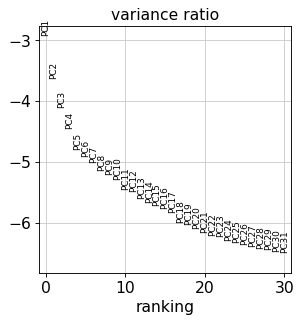

In [20]:
sc.pl.pca_variance_ratio(hca_adata, log=True)

In [22]:
Z = harmonize(hca_adata.obsm['X_pca'], hca_adata.obs, batch_key = 'sample', theta=.2, random_state=14)
hca_adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [23]:
sc.pp.neighbors(hca_adata, n_neighbors=30, n_pcs=18, random_state=14, use_rep='X_harmony')


computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:04:46)


In [24]:
save_adata(hca_adata, '../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.umap.h5ad')


In [25]:
sc.tl.umap(hca_adata, min_dist=.5, spread=1., random_state=14)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:15:50)


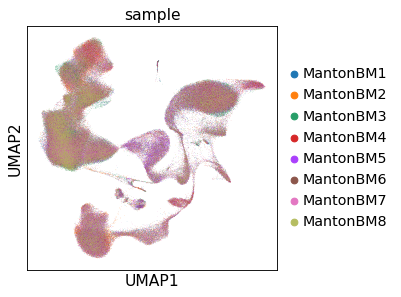

In [26]:
sc.pl.umap(hca_adata, color=['sample'])

In [27]:
save_adata(hca_adata, '../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.umap.h5ad')

In [28]:
hca_adata

AnnData object with n_obs × n_vars = 306011 × 22223 
    obs: 'doublet_score', 'mito_frac', 'predicted_doublet', 'sample', 'total_counts', 'n_counts'
    var: 'n_cells', 'CellCycle_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'X_harmony'
    varm: 'PCs'

In [ ]:
hca_adata = read_adata('../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.umap.h5ad')

In [31]:
sc.tl.leiden(hca_adata, resolution=1., random_state=14)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:29:32)


In [32]:
sc.tl.rank_genes_groups(hca_adata, groupby='leiden')

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/e

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:14)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


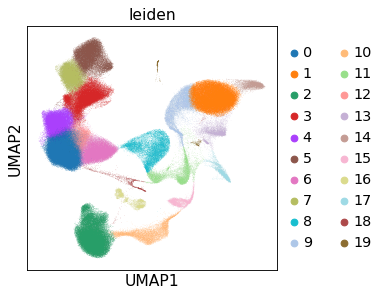

In [33]:
sc.pl.umap(hca_adata, color='leiden')

In [34]:
pd.DataFrame(hca_adata.uns['rank_genes_groups']['names']).head(20)

0         1          2       3         4       5              6  \
0      SARAF    TYROBP      CD79A    CCL5      IL7R    NKG7           CD8B   
1    PIK3IP1      FCN1       CD37    GZMK      IL32    GNLY  RP11-291B21.2   
2   LEPROTL1    S100A9       CD74   DUSP2       LTB    CST7           CD8A   
3       CD3E       FTL      MS4A1    CST7      JUNB   KLRF1           CD3D   
4       TRAC      CSTA  LINC00926    CMC1      TRAC   KLRD1            CD7   
5       CD3D      VCAN  TNFRSF13C    CD8A      RORA    GZMB           CD3E   
6        LTB      CTSS   HLA-DQB1    IL32   TNFAIP3    CTSW        PIK3IP1   
7        MAL    S100A8      BANK1    GZMM      CD3D    PRF1          S100B   
8       CCR7       LYZ    HLA-DRA    HCST       CD2    GZMA           TRAC   
9      TSHZ2     NAMPT      FCER2   CXCR4      CD3E  FGFBP2       LEPROTL1   
10      IL7R     NEAT1      BIRC3    RGS1       B2M     CD7         MALAT1   
11      LEF1      TYMP       CD83  PIK3R1  LEPROTL1   KLRB1          NELL2   
12    MALAT1   S100A12    RALGPS2    GZMA     GATA3   CD247           CCR7   
13     NOSIP   S100A11     ADAM28    CD3D      CD52    HOPX          SARAF   
14      JUNB      LST1      MEF2C   HLA-A   TNFRSF4    CCL5         MGAT4A   
15     RCAN3  SERPINA1       CD52    CTSW   ZFP36L2    TRDC          NOSIP   
16    BCL11B      CD14   HLA-DQA1    BTG1     KLRB1   SPON2            LCK   
17      CD3G       FOS   ARHGAP24    CD3E    SPOCK2    CMC1           LEF1   
18     TRBC2    CLEC7A    HLA-DMB    CD8B     SARAF   CLIC3          RPS27   
19     CAMK4      PSAP   HLA-DRB1     FYN     FXYD5    GZMM            EVL   

             7         8              9         10      11            12  \
0         NKG7    ATPIF1            LYZ      CD79B   RPS24       C1orf56   
1         CCL5     BLVRB         LGALS1    FAM129C   RPL31      CDC42SE1   
2         GZMH     HMGB1         RNASE2      PCDH9   RPL39      C16orf54   
3       FGFBP2     PRDX2           RETN      BCL7A   RPL34          CD3G   
4         GNLY      AHSP           CSTA      RCSD1   ZFAS1         PHKG1   
5         CST7    ATP5J2           SRGN      TCL1A   EIF3E         FOXP1   
6        HLA-C      YBX1         S100A8       SOX4   RPL26  RP11-138A9.2   
7         GZMA      FTH1           CYBA     VPREB3   RPL12       LRRC75A   
8          B2M      RPL8  RP11-1143G9.4      NEIL1    RPS6        RASSF3   
9         IL32     SNRPG           MNDA      CD79A    RPL7        TNRC6B   
10        CD3D      NME4         S100A9       CD24   RPL15          IL7R   
11        GZMM  KIAA0101        C4orf48       AFF3   RPS4X       PIK3IP1   
12  AC092580.4     RPLP0           JUND    TMEM243   RPL13        GIGYF1   
13        GZMB      SOD1            CFD    CCDC191   RPS15          CD3E   
14       KLRG1      GYPC            MPO  KIAA0226L  RPL35A          CCR7   
15       KLRD1     RPL35            GRN   C16orf74   RPS18           MAL   
16        CTSW    RANBP1          RAB32     NSMCE1    RPS8          MDM4   
17       HLA-B      UROD         PYCARD        MME    RPS9           LTB   
18       MYO1F    S100A6          MGST1      CMTM7   RPL32          TRAC   
19        HCST     UQCRQ           TSPO       IRF4   RPS3A         RGPD5   

          13        14       15       16        17        18        19  
0     TMSB10      LST1     DNTT     SSR4  C12orf75    PGRMC1     SEPP1  
1    HLA-DRA    TYROBP    CD79B   FKBP11      CD74    CAPZA2      APOE  
2       CD74      AIF1   VPREB3     MZB1      PLD4      RTN3    CXCL12  
3    HLA-DMA       FTL   VPREB1     VIMP     ITM2C      GMPR    MARCKS  
4   SH3BGRL3      SAT1   LAPTM5   SEC11C    SEC61B  SERPINB1     FCGRT  
5      COTL1     COTL1    IGLL1    SPCS2       APP     RGS18      CD63  
6   HLA-DRB1   S100A11    RCSD1    FKBP2   ALOX5AP   PRTFDC1       CFD  
7    S100A10      PSAP     SOX4     CYBA      NPC2     KIF2A      LEPR  
8       CYBA    FCER1G    SOCS2    SPCS1    CCDC50   NGFRAP1     VCAM1  
9       CST3      CTSS     TCF4     SELK     

In [38]:
remap = {'0':'T 2','1':'Mono_CD14 2', '2':'B 3', '3':'T 4',
 '4':'T 3', '5':'NK 1', '6':'T 1', '7':'T 5',
 '8':'Ery 1', '9':'Mono_CD14 1', '10':'B 2', '11':'HSC 1', '12':'T 6', '13':'cDC 1',
        '14':'Mono_CD16 1', '15':'B 1', '16':'Plasmablast 1', '17':'pDC 1', '18':'Megak 1', '19':'Macro 1'}


hca_adata.obs['leiden_lab'] = hca_adata.obs['leiden'].replace(remap)
hca_adata.obs['leiden_lab_group'] = hca_adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

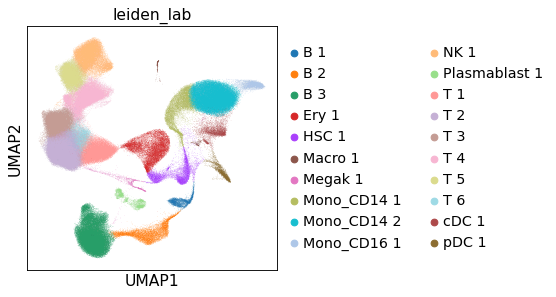

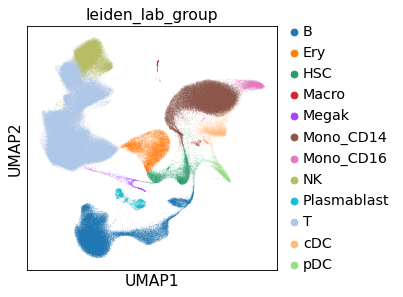

In [8]:
sc.pl.umap(hca_adata, color='leiden_lab')
sc.pl.umap(hca_adata, color='leiden_lab_group')

In [40]:
sc.tl.rank_genes_groups(hca_adata, groupby='leiden_lab')

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:03)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


In [41]:
pd.DataFrame(hca_adata.uns['rank_genes_groups']['names']).head(20)

B 1        B 2        B 3     Ery 1   HSC 1   Macro 1   Megak 1  \
0      DNTT      CD79B      CD79A    ATPIF1   RPS24     SEPP1    PGRMC1   
1     CD79B    FAM129C       CD37     BLVRB   RPL31      APOE    CAPZA2   
2    VPREB3      PCDH9       CD74     HMGB1   RPL39    CXCL12      RTN3   
3    VPREB1      BCL7A      MS4A1     PRDX2   RPL34    MARCKS      GMPR   
4    LAPTM5      RCSD1  LINC00926      AHSP   ZFAS1     FCGRT  SERPINB1   
5     IGLL1      TCL1A  TNFRSF13C    ATP5J2   EIF3E      CD63     RGS18   
6     RCSD1       SOX4   HLA-DQB1      YBX1   RPL26       CFD   PRTFDC1   
7      SOX4     VPREB3      BANK1      FTH1   RPL12      LEPR     KIF2A   
8     SOCS2      NEIL1    HLA-DRA      RPL8    RPS6     VCAM1   NGFRAP1   
9      TCF4      CD79A      FCER2     SNRPG    RPL7    IFITM3      DAD1   
10      CD9       CD24      BIRC3      NME4   RPL15      GAS6    NAP1L1   
11    CMTM7       AFF3       CD83  KIAA0101   RPS4X      GGT5    NT5C3A   
12   ZCCHC7    TMEM243    RALGPS2     RPLP0   RPL13        CP      RPA1   
13     CD99    CCDC191     ADAM28      SOD1   RPS15       MDK    IGSF10   
14    SSBP2  KIAA0226L      MEF2C      GYPC  RPL35A  SERPING1      SOD2   
15    TOP2B   C16orf74       CD52     RPL35   RPS18      HNMT     PRDX6   
16      MME     NSMCE1   HLA-DQA1    RANBP1    RPS8    PCOLCE      MEST   
17     EBF1        MME   ARHGAP24      UROD    RPS9   RARRES2      GPX4   
18    MLXIP      CMTM7    HLA-DMB    S100A6   RPL32      IGF2     SPARC   
19  HLA-DRA       IRF4   HLA-DRB1     UQCRQ   RPS3A   LAPTM4A     CCNG1   

      Mono_CD14 1 Mono_CD14 2 Mono_CD16 1    NK 1 Plasmablast 1  \
0             LYZ      TYROBP        LST1    NKG7          SSR4   
1          LGALS1        FCN1      TYROBP    GNLY        FKBP11   
2          RNASE2      S100A9        AIF1    CST7          MZB1   
3            RETN         FTL         FTL   KLRF1          VIMP   
4            CSTA        CSTA        SAT1   KLRD1        SEC11C   
5            SRGN        VCAN       COTL1    GZMB         SPCS2   
6          S100A8        CTSS     S100A11    CTSW         FKBP2   
7            CYBA      S100A8        PSAP    PRF1          CYBA   
8   RP11-1143G9.4         LYZ      FCER1G    GZMA         SPCS1   
9            MNDA       NAMPT        CTSS  FGFBP2          SELK   
10         S100A9       NEAT1    SERPINA1     CD7         PRDX4   
11        C4orf48        TYMP        FTH1   KLRB1          XBP1   
12           JUND     S100A12      IFITM2   CD247          SELM   
13            CFD     S100A11       NEAT1    HOPX        RABAC1   
14            MPO        LST1        SPI1    CCL5         PLPP5   
15            GRN    SERPINA1        NPC2    TRDC       TMEM258   
16          RAB32        CD14      S100A4   SPON2         ITM2C   
17         PYCARD         FOS      FCGR3A    CMC1         SPCS3   
18          MGST1      CLEC7A         CFD   CLIC3       HERPUD1   
19           TSPO        PSAP      STXBP2    GZMM         TRAM1   

              T 1       T 2       T 3     T 4         T 5           T 6  \
0            CD8B     SARAF      IL7R    CCL5        NKG7       C1orf56   
1   RP11-291B21.2   PIK3IP1      IL32    GZMK        CCL5      CDC42SE1   
2            CD8A  LEPROTL1       LTB   DUSP2        GZMH      C16orf54   
3            CD3D      CD3E      JUNB    CST7      FGFBP2          CD3G   
4             CD7      TRAC      TRAC    CMC1        GNLY         PHKG1   
5            CD3E      CD3D      RORA    CD8A        CST7         FOXP1   
6         PIK3IP1       LTB   TNFAIP3    IL32       HLA-C  RP11-138A9.2   
7           S100B       MAL      CD3D    GZMM        GZMA       LRRC75A   
8            TRAC      CCR7       CD2    HCST         B2M        RASSF3   
9        LEPROTL1     TSHZ2      CD3E   CXCR4        IL32        TNRC6B   
10         MALAT1      IL7R       B2M    RGS1        CD3D          IL7R   
11          NELL2      LEF1  LEPROTL1  PIK3R1        GZMM       PIK3IP1   
12           CCR7    MALAT1     GATA3    GZMA  AC

In [42]:
save_adata(hca_adata, '../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.umap.leiden.h5ad')

Only considering the two last: ['.leiden', '.h5ad'].
Only considering the two last: ['.leiden', '.h5ad'].


In [80]:
hca_adata = read_adata('../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.umap.leiden.h5ad')

Only considering the two last: ['.leiden', '.h5ad'].
Only considering the two last: ['.leiden', '.h5ad'].


In [81]:
pd.DataFrame(hca_adata.uns['rank_genes_groups']['names']).columns

Index(['B 1', 'B 2', 'B 3', 'Ery 1', 'HSC 1', 'Macro 1', 'Megak 1',
       'Mono_CD14 1', 'Mono_CD14 2', 'Mono_CD16 1', 'NK 1', 'Plasmablast 1',
       'T 1', 'T 2', 'T 3', 'T 4', 'T 5', 'T 6', 'cDC 1', 'pDC 1'],
      dtype='object')

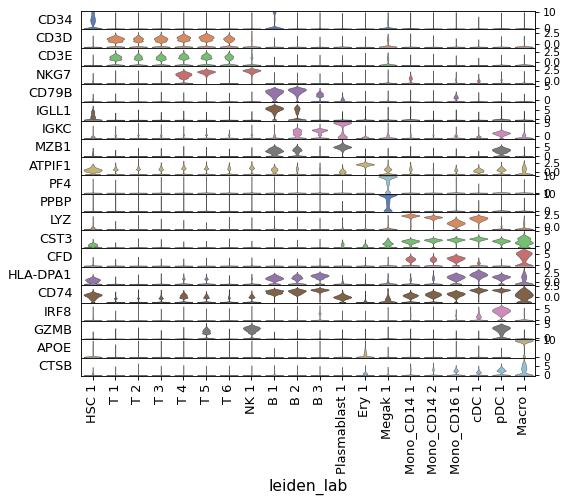

In [82]:
order = [ 'HSC 1','T 1', 'T 2', 'T 3', 'T 4', 'T 5', 'T 6', 'NK 1', 'B 1', 'B 2', 'B 3', 'Plasmablast 1', 'Ery 1', 'Megak 1',
         'Mono_CD14 1', 'Mono_CD14 2', 'Mono_CD16 1','cDC 1', 'pDC 1', 'Macro 1']



_ = sc.pl.stacked_violin(hca_adata, var_names=['CD34','CD3D', 'CD3E', 'NKG7',
                                         'CD79B', 'IGLL1','IGKC', 'MZB1',
                                         'ATPIF1','PF4', 'PPBP',
                                        'LYZ', 'CST3', 'CFD', 
                                         'HLA-DPA1', 'CD74', 'IRF8', 'GZMB',
                                        'APOE', 'CTSB'], order=order,
                     groupby='leiden_lab', use_raw=False, swap_axes=True)

In [119]:
hca_adata.obs['lineage'] = hca_adata.obs['leiden_lab_group'].replace({'pDC':'Mono/DC', 'cDC':'Mono/DC', 'Mono':'Mono/DC', 'Mono_CD16':'Mono/DC', 'Mono_CD14':'Mono/DC',
                                                          'Ery':'Erythroid', 'Megak':'Megakar.', 'Plasmablast':'Plasma.', 'Macro':'BM-Macro'})

## Make full HCA UMAP plot

In [120]:
hca_umap_data = hca_adata.obs.copy()
hca_umap_data['UMAP_1'] = hca_adata.obsm['X_umap'][:, 0]
hca_umap_data['UMAP_2'] = hca_adata.obsm['X_umap'][:, 1]

In [121]:
hca_umap_data['lineage'].unique()

array(['T', 'Mono/DC', 'B', 'NK', 'HSC', 'Erythroid', 'Megakar.',
       'BM-Macro', 'Plasma.'], dtype=object)

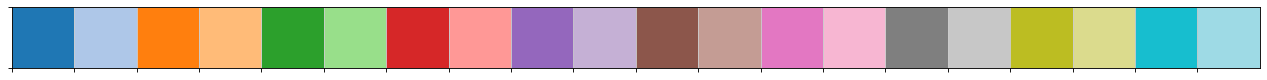

In [122]:
c = palettable.tableau.Tableau_20.hex_colors
sns.palplot(c)
celltype_cmap = {'B':c[0], 'T':c[3], 'Mono/DC':c[4], 'HSC':c[14], 'Megakar.':c[9], 'Erythroid':c[8], 'Gran.':c[15], 'NK':c[6], 'Plasma.':c[19], 'BM-Macro':c[11]}

In [123]:
hca_umap_data['lineage_color'] = hca_umap_data['lineage'].replace(celltype_cmap)

In [124]:
hca_umap_data['lineage_color'].unique()

array(['#FFBB78', '#2CA02C', '#1F77B4', '#D62728', '#7F7F7F', '#9467BD',
       '#C5B0D5', '#C49C94', '#9EDAE5'], dtype=object)

In [129]:
celltype_order_clean = ['HSC', 'B','Plasma.', 'Erythroid', 'Megakar.', 'Mono/DC', 'T', 'NK', 'BM-Macro']

In [213]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [131]:
box_height=1.3
box_width=1.3
title_height=.33
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.1
valdpi = 200

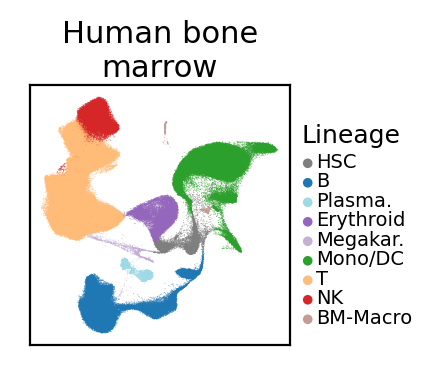

In [132]:
leg_width=.6
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(hca_umap_data['UMAP_1'], hca_umap_data['UMAP_2'], c=hca_umap_data['lineage_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.15
N = len(celltype_order_clean)
for (i,y) in enumerate(np.linspace(.7, .1, num=N)):
    ct = celltype_order_clean[i]
    legend_ax.scatter(marker_x, y, color=celltype_cmap[ct], s=12, edgecolor='None')
    legend_ax.text(marker_x+.07, y-.015, ct, fontsize=7)
legend_ax.text(.1, .78, 'Lineage', fontsize=9)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Human bone\nmarrow', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "HCA.BoneMarrow.scRNAseq.UMAP.pdf")
fig.savefig(figure_file, dpi=300)

## Subset the dataset to monocyte and DC lineage cells and repeat clustering

filtered out 14877 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:23)


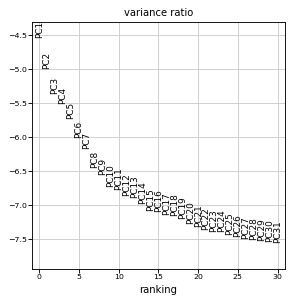

In [159]:
hca_mono_dc = sc.AnnData(hca_adata.raw.X, obs=hca_adata.obs, var=hca_adata.raw.var, uns=hca_adata.uns)
mono_DC_lineage = hca_adata.obs['lineage'].isin(['Mono/DC', 'HSC'])
hca_mono_dc = hca_mono_dc[mono_DC_lineage, :]
hca_mono_dc.raw = hca_mono_dc
hca_mono_dc = hca_mono_dc[:, ~hca_mono_dc.var['CellCycle_Genes']]
sc.pp.filter_genes(hca_mono_dc, min_cells=10)
sc.pp.normalize_per_cell(hca_mono_dc, counts_per_cell_after=10000)
sc.pp.log1p(hca_mono_dc)
sc.pp.highly_variable_genes(hca_mono_dc, n_top_genes=None)
sc.pp.scale(hca_mono_dc, max_value=10)
sc.tl.pca(hca_mono_dc, random_state=14, svd_solver='arpack', use_highly_variable=True, zero_center=True, )
sc.pl.pca_variance_ratio(hca_mono_dc, log=True)

In [160]:
Z = harmonize(hca_mono_dc.obsm['X_pca'], hca_mono_dc.obs, batch_key = 'sample', theta=.1, random_state=14)
hca_mono_dc.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [161]:
sc.pp.neighbors(hca_mono_dc, n_neighbors=30, n_pcs=15, random_state=14, use_rep='X_harmony')
sc.tl.umap(hca_mono_dc, min_dist=.5, spread=1.0, random_state=14)

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:11)


... storing 'lineage' as categorical


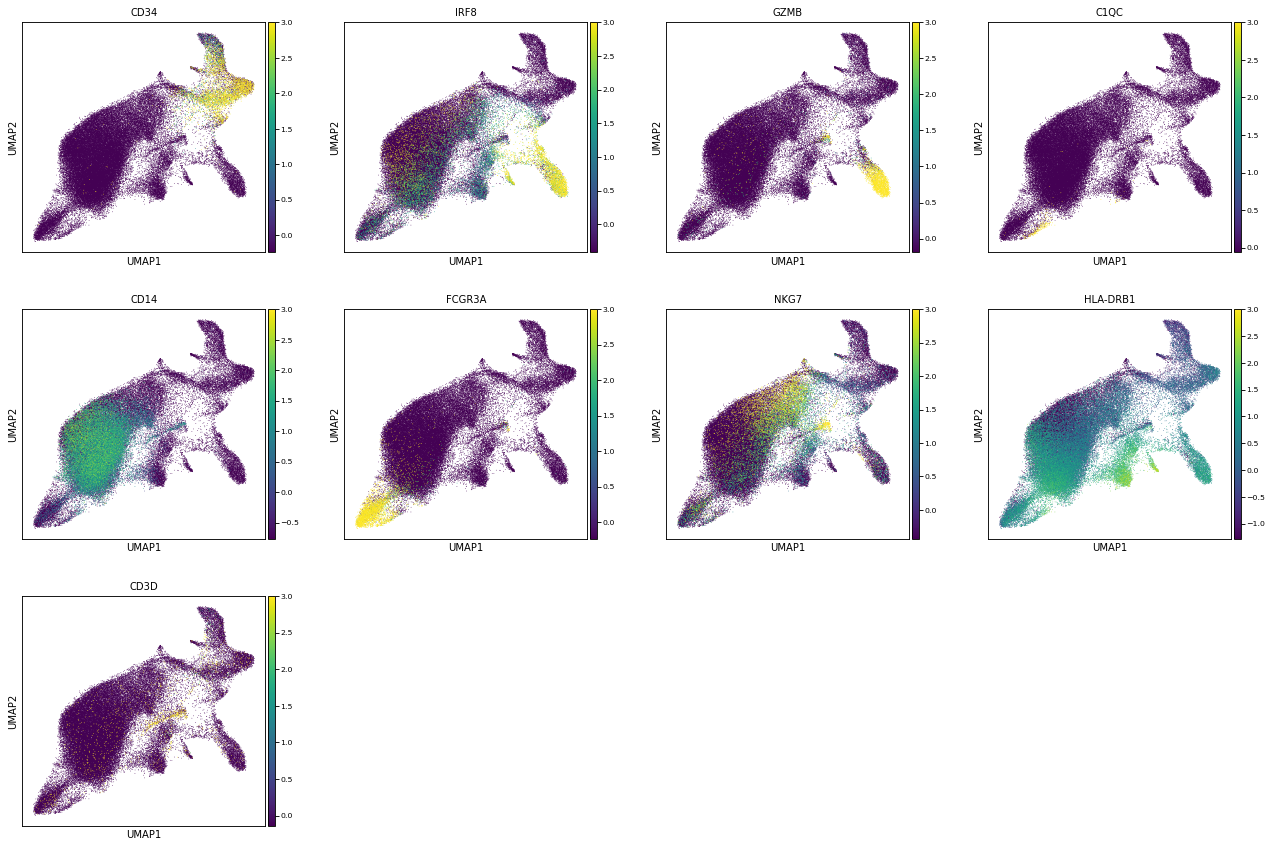

In [162]:
sc.pl.umap(hca_mono_dc, color=['CD34', 'IRF8', 'GZMB', 'C1QC', 'CD14', 'FCGR3A', 'NKG7', 'HLA-DRB1', 'CD3D'], use_raw=False, vmax=3)

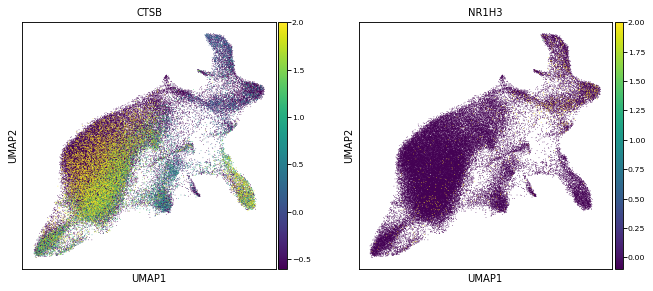

In [163]:
sc.pl.umap(hca_mono_dc, color=['CTSB', 'NR1H3'], use_raw=False, vmax=2)

In [168]:
sc.tl.leiden(hca_mono_dc, resolution=1.3, random_state=14)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:04:08)


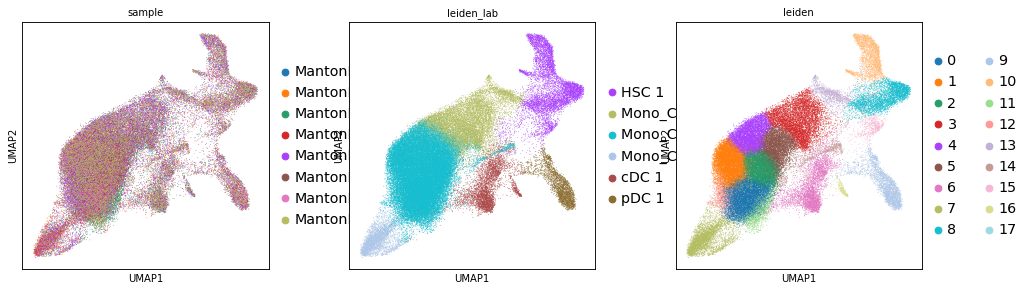

In [169]:
sc.pl.umap(hca_mono_dc, color=['sample', 'leiden_lab', 'leiden'])

In [170]:
sc.tl.rank_genes_groups(hca_mono_dc, groupby='leiden')

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:40)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


In [171]:
pd.DataFrame(hca_mono_dc.uns['rank_genes_groups']['names']).head(20)

0              1           2              3         4  \
0     TYROBP          NAMPT      S100A9            LYZ    S100A8   
1       CTSS           AQP9      S100A8           RETN   S100A12   
2      NEAT1          DUSP6     S100A12         RNASE2     S100P   
3     LGALS2        ZFP36L1        VCAN  RP11-1143G9.4      RETN   
4        FTL           DSC2        RBP7            MPO    S100A9   
5       CD14        CYP27A1        FCN1         LGALS1        HP   
6   SERPINA1           G0S2        CD14           NKG7      RBP7   
7       FCN1          CXCL8        QPCT           AZU1     ITGAM   
8     CLEC7A           VNN2       PLBD1      SERPINB10     CKAP4   
9       PSAP          DLEU7      S100A6        SLC44A1     PADI4   
10      FGL2          CMTM2      SLC2A3        MT-ND4L    CYP4F3   
11      TYMP         SEMA6B        CTSD           SRGN        F5   
12     DUSP1          BRSK1         CDA          MS4A3     VSTM1   
13    MS4A6A          THBS1      TYROBP        FAM101B       BPI   
14       FOS  RP11-367G18.1        CSTA        FAM107B     PROK2   
15   S100A11          VEGFA       NAMPT   RP11-84C10.2      QPCT   
16     AP1S2     CYP1B1-AS1      CYP1B1            CFD    CYP1B1   
17      VCAN         CLEC4D  CTB-61M7.2          RAB32      DYSF   
18    CD300E      LINC01094        NCF1         RNASE3      MGAM   
19      LY96         PFKFB3        VNN2           JUND  SERPINB2   

                5         6          7       8         9             10  \
0          S100A8      CD74       LST1   RPL31  C12orf75          RPL31   
1          S100A9    TMSB10       AIF1   RPL34    JCHAIN           RPS6   
2          LGALS1   HLA-DRA     IFITM2  RPL35A     ITM2C          RPL34   
3             LYZ  HLA-DRB1        FTL   EIF3E      PLD4          RPS27   
4            RETN      CST3       FTH1    RPS6    SEC61B          RPL12   
5            VCAN   HLA-DMA       SAT1   RPL13   ALOX5AP         RPS15A   
6            CTSD    TMSB4X      COTL1   ZFAS1       APP         RPL35A   
7            CES1  SH3BGRL3       PSAP   RPL11    CCDC50           RPS8   
8         S100A12  HLA-DPB1    S100A11   RPL15      IRF7          RPS25   
9            CSTA      ACTB     FCGR3A    RPL3      TCF4         RPL13A   
10         S100A6  HLA-DPA1     FCER1G    RPL7    LILRA4  RP11-620J15.3   
11           TSPO   S100A10   SERPINA1  RPL10A      UGCG          RPL15   
12          CKAP4      LSP1     TYROBP   RPL39      MZB1          RPL26   
13  RP11-1143G9.4     COTL1       CD52   RPS18  SERPINF1          RPS18   
14         RNASE2    ARPC1B     IFITM3    RPL5     SPCS1          RPL32   
15         MCEMP1     ANXA2       RHOC   RPL30      GZMB          RPL13   
16          PADI4      PFN1       CTSS   RPL12      CD74          RPS24   
17          ITGAM    FCER1A      MS4A7    RPS8      PLP2         RPL10A   
18           FCN1  HLA-DQB1  LINC01272   RPS4X     IL3RA           RPL3   
19           MNDA   HLA-DMB      TIMP1  GNB2L1  PPP1R14B          RPS14   

         11        12       13        14        15        16             17  
0     NAMPT     ISG15      MPO      CD3D    SPINK2   HLA-DRA            PF4  
1   ZFP36L1      IFI6   PRSS57      BTG1      SOX4      CD74           PPBP  
2      FTH1    IFI44L     AZU1      IL32     ACTG1  HLA-DPA1          GNG11  
3     CEBPB      LY6E    ELANE    MALAT1  KIAA0125  HLA-DPB1      HIST1H2AC  
4      MAFB      TYMP     CST7      CD3E     ZFAS1  HLA-DRB1       MAP3K7CL  
5     NEAT1     IFI44    RPS19       B2M     ITM2C  HLA-DQB1          RGS18  
6    TYROBP  APOBEC3A    PRTN3      NKG7    NAP1L1     RGS10           SDPR  
7     HIF1A      OAS3    RPL36       CD7     RPL15   HLA-DMA         S100A9  
8    NFKBIA      CTSS    RPL39      CCL5     RPL31      SNX3           VCAN  
9      SGK1       MX1    HSPB1      TRAC     PNISR   C1orf54           NRGN  
10   BCL2A1      SCO2    RPL35    BCL11B   HNRNPA1  HLA-DQA1           FCN1  
11      FTL      OAS2    MS4A3      CD3G     RPL19    TMSB4X          

## Remove doublets and re-cluster

filtered out 15368 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:22)


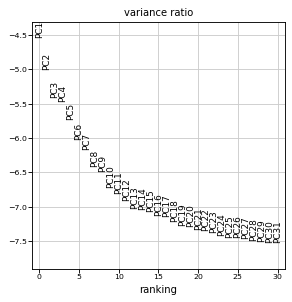

In [173]:
hca_mono_dc = sc.AnnData(hca_mono_dc.raw.X, obs=hca_mono_dc.obs, var=hca_mono_dc.raw.var, uns=hca_mono_dc.uns)
hca_mono_dc = hca_mono_dc[~hca_mono_dc.obs['leiden'].isin(['10', '14', '17']), :]
hca_mono_dc.raw = hca_mono_dc
hca_mono_dc = hca_mono_dc[:, ~hca_mono_dc.var['CellCycle_Genes']]
sc.pp.filter_genes(hca_mono_dc, min_cells=10)
sc.pp.normalize_per_cell(hca_mono_dc, counts_per_cell_after=10000)
sc.pp.log1p(hca_mono_dc)
sc.pp.highly_variable_genes(hca_mono_dc, n_top_genes=None)
sc.pp.scale(hca_mono_dc, max_value=10)
sc.tl.pca(hca_mono_dc, random_state=14, svd_solver='arpack', use_highly_variable=True, zero_center=True, )
sc.pl.pca_variance_ratio(hca_mono_dc, log=True)

In [174]:
Z = harmonize(hca_mono_dc.obsm['X_pca'], hca_mono_dc.obs, batch_key = 'sample', theta=.1, random_state=14)
hca_mono_dc.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [175]:
sc.pp.neighbors(hca_mono_dc, n_neighbors=30, n_pcs=13, random_state=14, use_rep='X_harmony')
sc.tl.umap(hca_mono_dc, min_dist=.5, spread=1.0, random_state=14)

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:04)


In [176]:
sc.tl.leiden(hca_mono_dc, resolution=.7, random_state=14)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:28)


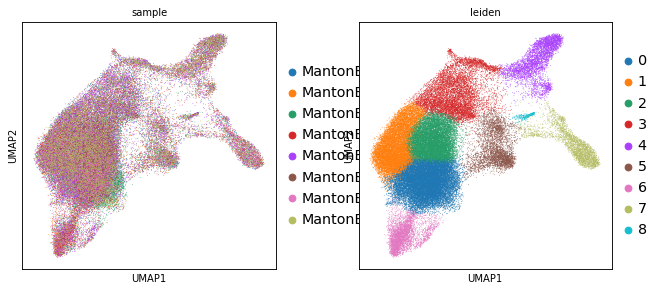

In [177]:
sc.pl.umap(hca_mono_dc, color=['sample', 'leiden'])

In [180]:
mapping = {'0':'Mono_CD14 4', '1':'Mono_CD14 3', '2':'Mono_CD14 2',
           '3':'Mono_CD14 1', '4':'HSC 1', '5':'cDC 1',
          '6':'Mono_CD16 1', '7':'pDC 1', '8':'cDC 2'}

In [181]:
hca_mono_dc.obs['leiden_lab'] = hca_mono_dc.obs['leiden'].replace(mapping)

In [183]:
hca_mono_dc.obs['leiden_lab_group'] = hca_mono_dc.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

In [182]:
sc.tl.rank_genes_groups(hca_mono_dc, groupby='leiden')

ranking genes


... storing 'leiden_lab' as categorical
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


In [179]:
pd.DataFrame(hca_mono_dc.uns['rank_genes_groups']['names']).head(20)

0             1        2              3       4         5  \
0     TYROBP         S100P   S100A9         RNASE2   RPL31      CD74   
1       CTSS       S100A12   S100A8            MPO   RPL34    TMSB10   
2      NEAT1         CMTM2  S100A12           RETN  RPL35A   HLA-DRA   
3        FTL        S100A8     VCAN           NKG7   EIF3E  HLA-DRB1   
4     LGALS2        CYP4F3   S100A6          MS4A3    RPS6      CST3   
5     CLEC7A          AQP9     CTSD           AZU1  GNB2L1   HLA-DMA   
6      NAMPT          ORM1    PLBD1            LYZ   RPL15  HLA-DPB1   
7    ZFP36L1         BRSK1     QPCT           SRGN    RPL3    TMSB4X   
8       CD14          RBP7     TSPO  RP11-1143G9.4   RPL13  SH3BGRL3   
9       FCN1          VNN3     FCN1        MT-ND4L    RPL5      ACTB   
10  SERPINA1          MGAM     RBP7          ATP5I  RPL10A      PFN1   
11     DUSP1      ANKRD34B    ITGAM      SERPINB10    RPS8  HLA-DPA1   
12     CEBPB            HP    CKAP4           LSM5   RPL11   S100A10   
13    NFKBIA    AC096574.5      CDA          PRTN3   RPS18    ARPC1B   
14      FTH1          DRC1     CD14          H2AFZ    RPS3    FCER1A   
15      MAFB          ORM2     CSTA          RAB32   RPL12      LSP1   
16      TYMP         MMP25    PADI4          NAA38   RPL30     COTL1   
17    CD300E  RP11-555M1.3     CES1          RPLP1    RPL7    S100A4   
18      SGK1    AC129492.1   MCEMP1         RNASE3   RPS27     UBA52   
19      SAT1           PRL   METTL9        HSP90B1    EEF2     ANXA2   

            6         7         8  
0        LST1  C12orf75   HLA-DRA  
1      IFITM2    JCHAIN      CD74  
2        AIF1    SEC61B  HLA-DPA1  
3        FTH1     ITM2C  HLA-DPB1  
4         FTL      PLD4  HLA-DRB1  
5        SAT1    CCDC50  HLA-DQB1  
6       COTL1   ALOX5AP     RGS10  
7      FCGR3A       APP      SNX3  
8        PSAP      TCF4   HLA-DMA  
9     S100A11      IRF7   C1orf54  
10     FCER1G    LILRA4    TMSB4X  
11   SERPINA1      UGCG  HLA-DQA1  
12       CD52     SPCS1    TMSB10  
13     TYROBP      MZB1      LSP1  
14       RHOC  SERPINF1     HLA-B  
15     IFITM3      PLP2      CST3  
16      MS4A7      GZMB      MYL6  
17       CTSS  PPP1R14B     ATP5E  
18  LINC01272      CD74      CPVL  
19      TIMP1     IL3RA       B2M

In [184]:
list(hca_mono_dc.obs['leiden_lab_group'].unique())

['Mono_CD14', 'HSC', 'cDC', 'pDC', 'Mono_CD16']

... storing 'leiden_lab_group' as categorical


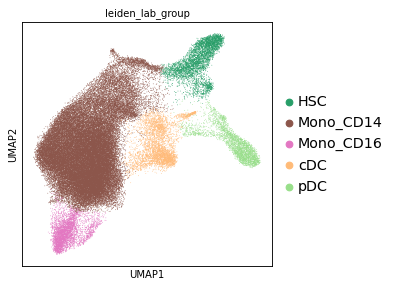

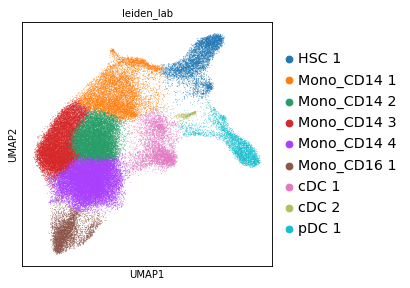

In [185]:
sc.pl.umap(hca_mono_dc, color='leiden_lab_group')
sc.pl.umap(hca_mono_dc, color='leiden_lab')

In [186]:
gsetdir = '../../../data/Genesets/msigdb'
combined_gset_fn = os.path.join(gsetdir,'c2andh.all.v6.2.symbols.gmt')
gset_merge, gset_genes = load_geneset(combined_gset_fn, genes=list(hca_mono_dc.raw.var.index), minsize=10)
ifn_genes = gset_merge['HECKER_IFNB1_TARGETS'].union(gset_merge['BROWNE_INTERFERON_RESPONSIVE_GENES']).union(gset_merge['MOSERLE_IFNA_RESPONSE']).union(gset_merge['HALLMARK_INTERFERON_ALPHA_RESPONSE']).union(gset_merge['HALLMARK_INTERFERON_GAMMA_RESPONSE'])

In [187]:
hca_mono_dc.var['ISG'] = hca_mono_dc.var.index.isin(ifn_genes)
hca_mono_dc.raw.var['ISG'] = hca_mono_dc.raw.var.index.isin(ifn_genes)

## Confirm labels by projecting into the human PBMC space

In [188]:
adata_query = sc.AnnData(hca_mono_dc.raw.X, obs=hca_mono_dc.obs, var=hca_mono_dc.raw.var, uns=hca_mono_dc.uns)
adata_query.raw = adata_query
adata_query = adata_query[:, ~adata_query.var['CellCycle_Genes'] & ~adata_query.var['ISG']]
sc.pp.filter_genes(adata_query, min_cells=10)

filtered out 15363 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


In [189]:
pbmc_fn = '../../../data/HCA_BoneMarrow/PBMC/Merge/Merged.10X.V3.PBMC.processed.h5ad'
pbmc_adata = read_adata(pbmc_fn, gcs=False)

Only considering the two last: ['.processed', '.h5ad'].
Only considering the two last: ['.processed', '.h5ad'].


In [190]:
adata_ref = sc.AnnData(X=pbmc_adata.raw.X, var=pbmc_adata.raw.var, obs=pbmc_adata.obs, uns=pbmc_adata.uns)
adata_ref.var_names_make_unique()
sc.pp.filter_genes(adata_ref, min_cells=10)
adata_ref = adata_ref[:,~adata_ref.var_names.str.startswith('MT-')]

filtered out 11976 genes that are detectedin less than 10 cells


In [191]:
hf.classifier_find_shared_genes(adata_ref, adata_query)
print(adata_ref.var['valid_for_classification'].sum(), adata_query.var['valid_for_classification'].sum())


Trying to set attribute `.var` of view, copying.


14280 14280


In [192]:
hf.classifier_learn_pca_projection(adata_ref, n_pcs=50)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [193]:
hf.classifier_apply_pca_projection(adata_ref, adata_query)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [194]:
adata_ref.obs['leiden_lab_group_clean'] = adata_ref.obs['leiden_lab_group'].replace({'Tc':'T CD8+', 'Th':'T CD4+', 'Mono_CD14':'Mono CD14+', 'Mono_CD16':'Mono CD16+', 'Plasmablast':'Plasma.'})


In [195]:
hca_mono_dc.obs['PBMC_Assignment'] = adata_ref.obs.iloc[adata_query.obsm['projection_neighbors'][:,0],:]['leiden_lab_group_clean'].values

... storing 'PBMC_Assignment' as categorical


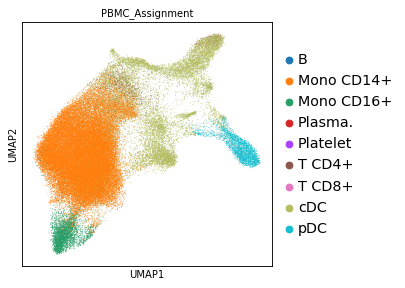

In [196]:
sc.pl.umap(hca_mono_dc, color='PBMC_Assignment')

In [197]:
hca_mono_dc.obs['leiden_lab_group'].value_counts()

Mono_CD14    50077
HSC           4429
cDC           4264
Mono_CD16     3924
pDC           2951
Name: leiden_lab_group, dtype: int64

In [198]:
hca_mono_dc.obs['leiden_lab'].value_counts()

Mono_CD14 4    18218
Mono_CD14 3    11944
Mono_CD14 2    11875
Mono_CD14 1     8040
HSC 1           4429
cDC 1           3976
Mono_CD16 1     3924
pDC 1           2951
cDC 2            288
Name: leiden_lab, dtype: int64

In [203]:
hca_mono_dc.obs['cluster_clean'] = hca_mono_dc.obs['leiden_lab_group'].copy()
hca_mono_dc.obs['cluster_clean'] = hca_mono_dc.obs['leiden_lab_group'].apply(lambda x: 'BM-' + x.replace('_', ' ').replace('CD14', 'CD14+').replace('CD16', 'CD16+').replace('Mono', 'MP'))
hca_mono_dc.obs['cluster_clean'] = hca_mono_dc.obs['cluster_clean'].astype(str)
hca_mono_dc.obs['cluster_clean'].value_counts()

BM-MP CD14+    50077
BM-HSC          4429
BM-cDC          4264
BM-MP CD16+     3924
BM-pDC          2951
Name: cluster_clean, dtype: int64

In [204]:
hca_mono_dc.obs['cluster_clean_full'] = hca_mono_dc.obs['leiden_lab_group'].copy().astype(str)

ind = hca_mono_dc.obs['cluster_clean_full'] == 'Mono_CD14'
hca_mono_dc.obs.loc[ind, 'cluster_clean_full'] = hca_mono_dc.obs.loc[ind, 'leiden_lab']

hca_mono_dc.obs['cluster_clean_full'] = hca_mono_dc.obs['cluster_clean_full'].apply(lambda x: 'BM-' + x.replace('_', ' ').replace('CD14', 'CD14+').replace('CD16', 'CD16+').replace('Mono', 'MP'))
hca_mono_dc.obs['cluster_clean_full'] = hca_mono_dc.obs['cluster_clean_full'].astype(str)
hca_mono_dc.obs['cluster_clean_full'].value_counts()

BM-MP CD14+ 4    18218
BM-MP CD14+ 3    11944
BM-MP CD14+ 2    11875
BM-MP CD14+ 1     8040
BM-HSC            4429
BM-cDC            4264
BM-MP CD16+       3924
BM-pDC            2951
Name: cluster_clean_full, dtype: int64

In [3]:
monodc_hca_path = '../../../data/HCA_BoneMarrow/ica_bone_marrow_merged_doubfilt_v2.MonoDC.umap.leiden.h5ad'

In [206]:
save_adata(hca_mono_dc, monodc_hca_path)

Only considering the two last: ['.leiden', '.h5ad'].
Only considering the two last: ['.leiden', '.h5ad'].


... storing 'cluster_clean' as categorical
... storing 'cluster_clean_full' as categorical


In [4]:
hca_mono_dc = read_adata(monodc_hca_path)

Only considering the two last: ['.leiden', '.h5ad'].
Only considering the two last: ['.leiden', '.h5ad'].


In [5]:
hca_mono_dc

AnnData object with n_obs × n_vars = 65645 × 18163 
    obs: 'doublet_score', 'mito_frac', 'predicted_doublet', 'sample', 'total_counts', 'n_counts', 'leiden', 'leiden_lab', 'leiden_lab_group', 'lineage', 'PBMC_Assignment', 'cluster_clean', 'cluster_clean_full'
    var: 'CellCycle_Genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ISG'
    uns: 'PBMC_Assignment_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

## Plot UMAPs for myeloid lineage bone marrow

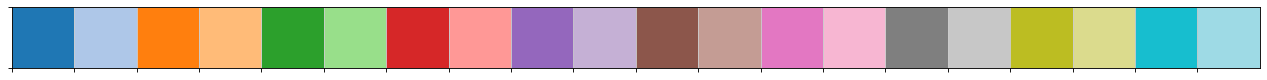

In [6]:
c = palettable.tableau.Tableau_20.hex_colors
sns.palplot(c)

In [7]:
hca_mono_dc.obs['cluster_clean'].unique()

[BM-MP CD14+, BM-HSC, BM-cDC, BM-pDC, BM-MP CD16+]
Categories (5, object): [BM-MP CD14+, BM-HSC, BM-cDC, BM-pDC, BM-MP CD16+]

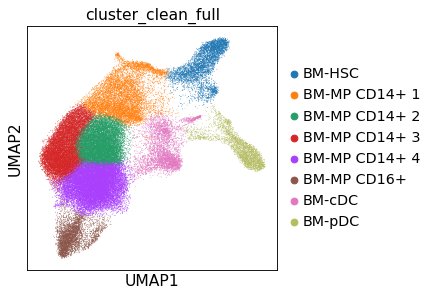

In [8]:
sc.pl.umap(hca_mono_dc, color='cluster_clean_full')

In [9]:
plotdata = hca_mono_dc.obs[['sample','leiden_lab', 'leiden_lab_group', 'PBMC_Assignment', 'cluster_clean', 'cluster_clean_full']]
plotdata['UMAP_1'] = hca_mono_dc.obsm['X_umap'][:,0]
plotdata['UMAP_2'] = hca_mono_dc.obsm['X_umap'][:,1]


ct_cmap = {'BM-HSC':c[14], 'BM-cDC':c[10], 'BM-pDC':c[11], 'BM-MP CD16+':c[6], 'BM-MP CD14+ 1':c[0], 'BM-MP CD14+ 2':c[1], 'BM-MP CD14+ 3':c[2], 'BM-MP CD14+ 4':c[3]}
celltype_order_clean = ['BM-HSC', 'BM-pDC', 'BM-cDC', 'BM-cDC','BM-MP CD14+ 1', 'BM-MP CD14+ 2', 'BM-MP CD14+ 3', 'BM-MP CD14+ 4', 'BM-MP CD16+']
plotdata['cluster_clean_color'] = plotdata['cluster_clean_full'].replace(ct_cmap)


assignment_colors =  {'B':c[0], 'Plasma.':c[19], 'T CD8+':c[3], 'T CD4+':c[2], 'NK':c[6], 'ISG-hi':c[7], 'Mono CD14+':c[4],
                   'Mono CD16+':c[5], 'cDC':c[10], 'pDC':c[11],'Replicating':c[12], 'Platelet':c[9]}
plotdata['pbmc_assignment_color'] = plotdata['PBMC_Assignment'].replace(assignment_colors)
assignment_order = ['T CD4+', 'T CD8+', 'NK', 'B', 'Plasma.',
                        'Mono CD14+', 'Mono CD16+', 'pDC', 'cDC', 'Platelet']



/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [10]:
hca_mono_dc

AnnData object with n_obs × n_vars = 65645 × 18163 
    obs: 'doublet_score', 'mito_frac', 'predicted_doublet', 'sample', 'total_counts', 'n_counts', 'leiden', 'leiden_lab', 'leiden_lab_group', 'lineage', 'PBMC_Assignment', 'cluster_clean', 'cluster_clean_full'
    var: 'CellCycle_Genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ISG'
    uns: 'PBMC_Assignment_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'cluster_clean_full_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

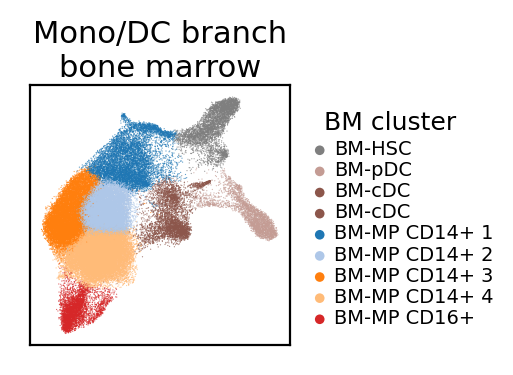

In [11]:
box_height=1.3
box_width=1.3
title_height=.33
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.2
valdpi = 200

leg_width=1.
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(plotdata['UMAP_1'], plotdata['UMAP_2'], c=plotdata['cluster_clean_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.15
N = len(celltype_order_clean)
for (i,y) in enumerate(np.linspace(.75, .1, num=N)):
    ct = celltype_order_clean[i]
    legend_ax.scatter(marker_x, y, color=ct_cmap[ct], s=12, edgecolor='None')
    legend_ax.text(marker_x+.07, y-.015, ct, fontsize=7)
legend_ax.text(.5, .83, 'BM cluster', fontsize=9, ha='center')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Mono/DC branch\nbone marrow', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "HCA.BoneMarrow.MyeloidLineage.scRNAseq.UMAP.pdf")
fig.savefig(figure_file, dpi=300)

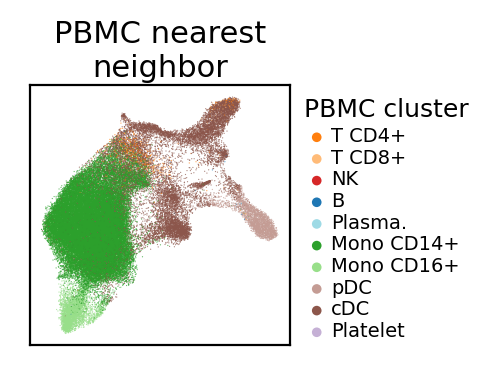

In [12]:
box_height=1.3
box_width=1.3
title_height=.33
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.2
valdpi = 200

leg_width=.9
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(plotdata['UMAP_1'], plotdata['UMAP_2'], c=plotdata['pbmc_assignment_color'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.15
N = len(assignment_order)
for (i,y) in enumerate(np.linspace(.8, .05, num=N)):
    ct = assignment_order[i]
    legend_ax.scatter(marker_x, y, color=assignment_colors[ct], s=12, edgecolor='None')
    legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.08, .88, 'PBMC cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'PBMC nearest\nneighbor', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "HCA.BoneMarrow.MyeloidLineage.PBMCassignment.UMAP.pdf")
fig.savefig(figure_file, dpi=300)

## Merge monocyte BM branch and PBMC monocytes

In [13]:

pbmc_fn = '../../../data/HCA_BoneMarrow/PBMC/Merge/Merged.10X.V3.PBMC.processed.h5ad'


pbmc_adata = read_adata(pbmc_fn, gcs=False)
pbmc_adata = sc.AnnData(X=pbmc_adata.raw.X, var=pbmc_adata.raw.var, obs=pbmc_adata.obs, uns=pbmc_adata.uns)
keep = pbmc_adata.obs['leiden_lab_group'].isin(['Mono_CD14+', 'Mono_CD16+', 'Mono_CD14', 'Mono_CD16'])
pbmc_mono = pbmc_adata[keep,:].copy()
pbmc_mono

Only considering the two last: ['.processed', '.h5ad'].
Only considering the two last: ['.processed', '.h5ad'].


AnnData object with n_obs × n_vars = 18198 × 33538 
    obs: 'barcode', 'batch', 'file', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'leiden', 'leiden_lab', 'leiden_lab_group'
    var: 'gene_ids', 'feature_types', 'genome', 'Mito_Gene'
    uns: 'file_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups'

In [14]:
pbmc_mono_merge = pbmc_mono.copy()
pbmc_mono_merge.obs['cluster_clean'] = pbmc_mono_merge.obs['leiden_lab_group'].apply(lambda x: 'PBMC-' + x.replace('_', ' ') + '+')
pbmc_mono_merge.obs['cluster_clean_full'] = pbmc_mono_merge.obs['leiden_lab_group'].apply(lambda x: 'PBMC-' + x.replace('_', ' ') + '+')
pbmc_mono_merge.obs['cluster_clean_full'].unique()

[PBMC-Mono CD14+, PBMC-Mono CD16+]
Categories (2, object): [PBMC-Mono CD14+, PBMC-Mono CD16+]

In [15]:
pbmc_mono_merge.obs['cluster_clean'].unique()

[PBMC-Mono CD14+, PBMC-Mono CD16+]
Categories (2, object): [PBMC-Mono CD14+, PBMC-Mono CD16+]

In [16]:
hca_mono_dc.obs['cluster_clean_full'].unique()

[BM-MP CD14+ 2, BM-HSC, BM-cDC, BM-MP CD14+ 4, BM-MP CD14+ 3, BM-MP CD14+ 1, BM-pDC, BM-MP CD16+]
Categories (8, object): [BM-MP CD14+ 2, BM-HSC, BM-cDC, BM-MP CD14+ 4, BM-MP CD14+ 3, BM-MP CD14+ 1, BM-pDC, BM-MP CD16+]

In [17]:
hca_mono_dc.obs['cluster_clean'].unique()

[BM-MP CD14+, BM-HSC, BM-cDC, BM-pDC, BM-MP CD16+]
Categories (5, object): [BM-MP CD14+, BM-HSC, BM-cDC, BM-pDC, BM-MP CD16+]

In [18]:
ind = hca_mono_dc.obs['cluster_clean'].isin(['BM-HSC', 'BM-MP CD14+','BM-MP CD16+'])
hca_mono = hca_mono_dc[ind, :].copy()
hca_mono = sc.AnnData(X=hca_mono.raw.X, obs=hca_mono.obs, var=hca_mono.raw.var, uns=hca_mono.uns)
hca_mono.raw = hca_mono
hca_mono = hca_mono[:, ~hca_mono.var['CellCycle_Genes'] & ~hca_mono.var['ISG']]
#sc.pp.filter_genes(hca_mono, min_cells=10)
hca_mono

View of AnnData object with n_obs × n_vars = 58430 × 33242 
    obs: 'doublet_score', 'mito_frac', 'predicted_doublet', 'sample', 'total_counts', 'n_counts', 'leiden', 'leiden_lab', 'leiden_lab_group', 'lineage', 'PBMC_Assignment', 'cluster_clean', 'cluster_clean_full'
    var: 'CellCycle_Genes', 'ISG'
    uns: 'PBMC_Assignment_colors', 'leiden', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'cluster_clean_full_colors'

In [19]:
hca_mono_pbmc = hca_mono.copy()
overlap = pbmc_mono_merge.var.index[pbmc_mono_merge.var.index.isin(hca_mono_pbmc.var.index)]
pbmc_mono_merge = pbmc_mono_merge[:,overlap]
hca_mono_pbmc = hca_mono_pbmc[:,overlap]

In [20]:
len(overlap)

21717

In [21]:
pbmc_mono_merge.obs['sample'] = pbmc_mono_merge.obs['file'].apply(lambda x: x.replace('_filtered_feature_bc_matrix.h5', ''))
pbmc_mono_merge.obs['sample'].value_counts()

Trying to set attribute `.obs` of view, copying.


5k_pbmc_NGSC3_aggr            9908
pbmc_10k_v3                   2612
pbmc_10k_protein_v3           1886
5k_pbmc_protein_v3_nextgem    1153
5k_pbmc_protein_v3            1014
5k_pbmc_v3                     868
5k_pbmc_v3_nextgem             757
Name: sample, dtype: int64

In [22]:
pbmc_mono_merge.obs = pbmc_mono_merge.obs[['n_counts', 'cluster_clean', 'cluster_clean_full', 'sample']]
pbmc_mono_merge.obs['Dataset'] = 'PBMC'
hca_mono_pbmc.obs = hca_mono_pbmc.obs[['n_counts','cluster_clean', 'cluster_clean_full', 'sample']]
hca_mono_pbmc.obs['Dataset'] = 'Marrow'
#hca_mono_pbmc.var.drop(['highly_variable', 'highly_variable_prefilt'], inplace=True, axis=1)
pbmc_mono_merge.var = hca_mono_pbmc.var
hca_mono_pbmc = hca_mono_pbmc.concatenate(pbmc_mono_merge)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:1880: UserWarning: Only some adata objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [23]:
sc.pp.filter_genes(hca_mono_pbmc, min_cells=10)

filtered out 6660 genes that are detectedin less than 10 cells


In [24]:
pd.crosstab(hca_mono_pbmc.obs['Dataset'], hca_mono_pbmc.obs['cluster_clean'])

cluster_clean  BM-HSC  BM-MP CD14+  BM-MP CD16+  PBMC-Mono CD14+  \
Dataset                                                            
Marrow           4429        50077         3924                0   
PBMC                0            0            0            17216   

cluster_clean  PBMC-Mono CD16+  
Dataset                         
Marrow                       0  
PBMC                       982

In [25]:
pd.crosstab(hca_mono_pbmc.obs['Dataset'], hca_mono_pbmc.obs['cluster_clean_full'])

cluster_clean_full  BM-HSC  BM-MP CD14+ 1  BM-MP CD14+ 2  BM-MP CD14+ 3  \
Dataset                                                                   
Marrow                4429           8040          11875          11944   
PBMC                     0              0              0              0   

cluster_clean_full  BM-MP CD14+ 4  BM-MP CD16+  PBMC-Mono CD14+  \
Dataset                                                           
Marrow                      18218         3924                0   
PBMC                            0            0            17216   

cluster_clean_full  PBMC-Mono CD16+  
Dataset                              
Marrow                            0  
PBMC                            982

In [26]:
hca_mono_pbmc.raw = hca_mono_pbmc.copy()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes


... storing 'Dataset' as categorical
... storing 'cluster_clean' as categorical
... storing 'cluster_clean_full' as categorical
... storing 'sample' as categorical


    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:25)


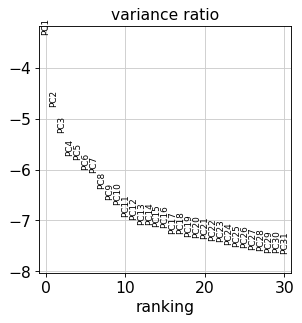

In [27]:
sc.pp.normalize_per_cell(hca_mono_pbmc, counts_per_cell_after=10000)
sc.pp.log1p(hca_mono_pbmc)
sc.pp.highly_variable_genes(hca_mono_pbmc, n_top_genes=None, batch_key='Dataset')
sc.pp.scale(hca_mono_pbmc, max_value=10)
hca_mono_pbmc.var['highly_variable'] = hca_mono_pbmc.var['highly_variable_nbatches']>=1
sc.tl.pca(hca_mono_pbmc, random_state=14, svd_solver='arpack', use_highly_variable=True, zero_center=True, )
sc.pl.pca_variance_ratio(hca_mono_pbmc, log=True)

In [28]:
Z = harmonize(hca_mono_pbmc.obsm['X_pca'], hca_mono_pbmc.obs, batch_key = 'sample', theta=.05, random_state=14)
hca_mono_pbmc.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [29]:
sc.pp.neighbors(hca_mono_pbmc, n_neighbors=30, n_pcs=13, random_state=14, use_rep='X_harmony') # 10X-V3-Merge

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:58)


In [30]:
sc.tl.umap(hca_mono_pbmc, min_dist=.5, spread=1.0, random_state=14)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:22)


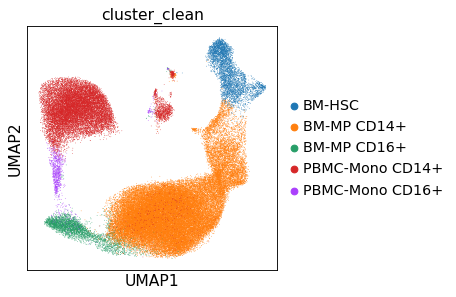

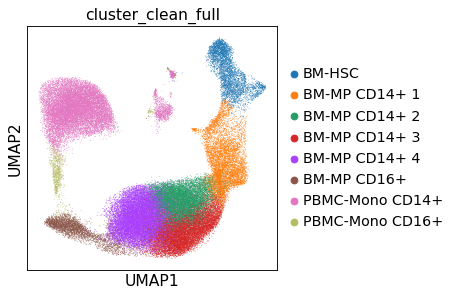

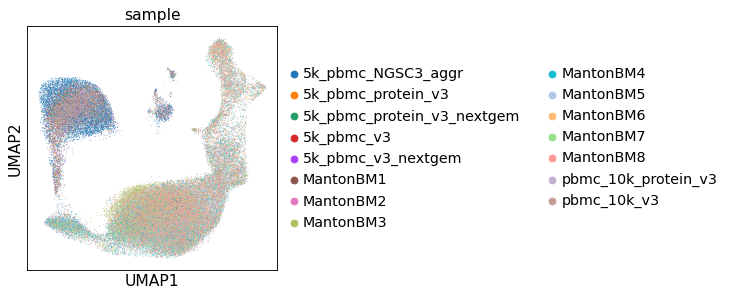

In [31]:
sc.pl.umap(hca_mono_pbmc, color='cluster_clean')
sc.pl.umap(hca_mono_pbmc, color='cluster_clean_full')
sc.pl.umap(hca_mono_pbmc, color='sample')

In [262]:
hca_mono_pbmc_noscale = sc.AnnData(hca_mono_pbmc.raw.X, obs=hca_mono_pbmc.obs, var=hca_mono_pbmc.raw.var, uns=hca_mono_pbmc.uns)
sc.pp.filter_genes(hca_mono_pbmc_noscale, min_cells=10)
sc.pp.normalize_per_cell(hca_mono_pbmc_noscale, counts_per_cell_after=10000)
sc.pp.log1p(hca_mono_pbmc_noscale)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [357]:
import magic
magic_operator = magic.MAGIC(knn_dist='cosine', t=3, random_state=14, n_jobs=15)
X_magic = magic_operator.fit_transform(hca_mono_pbmc_noscale, genes=['CD14', 'FCGR3A', 'MPO', 'AZU1', 'CD34'])

Calculating MAGIC...
  Running MAGIC on 76628 cells and 15057 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 100.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 251.75 seconds.
    Calculating affinities...
    Calculated affinities in 248.26 seconds.
  Calculated graph and diffusion operator in 601.01 seconds.
  Calculating imputation...
  Calculated imputation in 0.09 seconds.
Calculated MAGIC in 601.46 seconds.


/home/dkotliar/.local/lib/python3.7/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [358]:
X_magic

AnnData object with n_obs × n_vars = 76628 × 5 
    obs: 'Dataset', 'batch', 'cluster_clean', 'cluster_clean_full', 'n_counts', 'sample'
    var: 'CellCycle_Genes', 'ISG', 'n_cells'

In [359]:
plotdata_bm_pbmc = hca_mono_pbmc.obs.copy()
plotdata_bm_pbmc['UMAP_1'] = hca_mono_pbmc.obsm['X_umap'][:,0]
plotdata_bm_pbmc['UMAP_2'] = hca_mono_pbmc.obsm['X_umap'][:,1]
genes = ['CD14', 'FCGR3A', 'MPO', 'AZU1', 'CD34']
for g in genes:
    #plotdata_bm_pbmc[g] = hca_mono_pbmc.obs_vector(g)
    plotdata_bm_pbmc[g] = X_magic.obs_vector(g)

plotdata_bm_pbmc['annot'] = plotdata_bm_pbmc['cluster_clean_full']
ct_cmap = {'BM-HSC':c[14], 'BM-MP CD14+ 1':c[0], 'BM-MP CD14+ 2':c[1], 'BM-MP CD14+ 3':c[2], 'BM-MP CD14+ 4':c[3], 'BM-MP CD16+':c[6], 'PBMC-Mono CD14+':c[4], 'PBMC-Mono CD16+':c[5]}
plotdata_bm_pbmc['annot_color'] = plotdata_bm_pbmc['annot'].replace(ct_cmap)
plotdata_bm_pbmc['annot_color'].unique()

array(['#AEC7E8', '#7F7F7F', '#FFBB78', '#FF7F0E', '#1F77B4', '#D62728',
       '#2CA02C', '#98DF8A'], dtype=object)

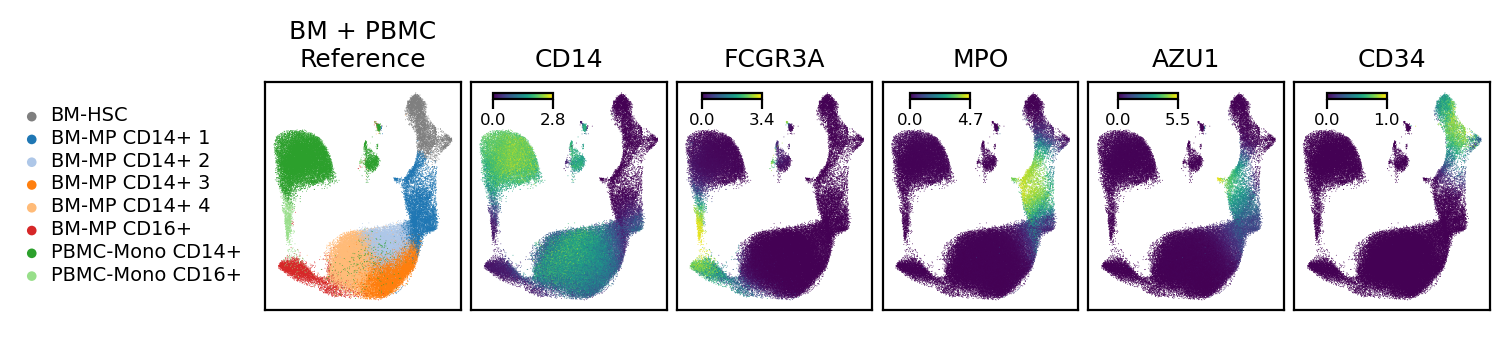

In [360]:
width = 7.5
height = 1.7
dotsize=.5
ncols = 6
nrows = 1

leg_width = 1.
heatmap_width = (6-leg_width)/ncols
dotsize=.1

fig = plt.figure(figsize=(width, height), dpi=200)
gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols+1,
        wspace=0.05,
        hspace=0.25,
        width_ratios=([leg_width] + [heatmap_width]*ncols),
        left=0.01, right=.99, bottom=.08, top=.75)

axes = []
for i in range(1, ncols+1):
    axes.append(fig.add_subplot(gs[i], xticks=[], yticks=[]))

leg_ax = fig.add_subplot(gs[0, 0], xticks=[], yticks=[], frameon=False) 

axes[0].scatter(plotdata_bm_pbmc['UMAP_1'], plotdata_bm_pbmc['UMAP_2'], c=plotdata_bm_pbmc['annot_color'], edgecolor='None',
                    label=None, s=dotsize, rasterized=True)
axes[0].set_title('BM + PBMC\nReference')

celltype_order_clean = ['BM-HSC', 'BM-MP CD14+ 1', 'BM-MP CD14+ 2', 'BM-MP CD14+ 3', 'BM-MP CD14+ 4', 'BM-MP CD16+', 'PBMC-Mono CD14+', 'PBMC-Mono CD16+']
leg_ax.set_ylim([0, 1])
leg_ax.set_xlim([0, 1])
marker_x=.05
N = len(celltype_order_clean)
for (i,y) in enumerate(np.linspace(.85, .15, num=N)):
    ct = celltype_order_clean[i]
    leg_ax.scatter(marker_x, y, color=ct_cmap[ct], s=12, edgecolor='None')
    leg_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
#leg_ax.text(.1, .72, 'Population', fontsize=9)


widths = np.array([leg_width] + [heatmap_width]*ncols)
widths_norm = widths / widths.sum()
offset = 0.02
xpos = np.cumsum(widths_norm)+offset
xpos = xpos[1:-1]

for (i,g) in enumerate(genes):
    Z = plotdata_bm_pbmc #sort_values(by=g, ascending=True)
    vmin = Z[g].min()
    vmax = Z[g].max()
    cim = axes[i+1].scatter(Z['UMAP_1'], Z['UMAP_2'], c=Z[g], edgecolor='None',
                    label=None, s=dotsize, rasterized=True)
    axes[i+1].set_title(g)
    cax = fig.add_axes([xpos[i], 0.7, 0.04, 0.02])
    fig.colorbar(cim, cax=cax, orientation='horizontal', ticks=[vmin, vmax])
    cax.tick_params(labelsize=6) 
    cax.set_xticklabels(['%.1f' % x for x in [vmin, vmax]])

    
figure_file = os.path.join(results_dir, "HCA.BoneMarrowPBMC.MonoLineage.MarkerUMAPs.pdf")
fig.savefig(figure_file, dpi=200)

In [263]:
hca_mono_pbmc_noscale

AnnData object with n_obs × n_vars = 76628 × 15057 
    obs: 'Dataset', 'batch', 'cluster_clean', 'cluster_clean_full', 'n_counts', 'sample'
    var: 'CellCycle_Genes', 'ISG', 'n_cells'
    uns: 'pca', 'neighbors', 'cluster_clean_colors', 'cluster_clean_full_colors', 'sample_colors', 'rank_genes_groups'

In [350]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [351]:
[x for x in hca_mono_pbmc_noscale.var.index if 'HLA' in x]

['HHLA3',
 'HHLA2',
 'HLA-E',
 'HLA-DRA',
 'HLA-DRB5',
 'HLA-DQB1',
 'HLA-DQB1-AS1',
 'HLA-DQA2',
 'HLA-DQB2',
 'HLA-DOB',
 'HLA-DMB',
 'HLA-DOA',
 'HLA-DPA1',
 'HLA-DPB1']

In [362]:
genes = []
genes_to_plot = ['CD34','MPO', 'AZU1', 'S100A8', 'S100A9', 'PLAC8', 'S100P', 'CD14', 'HLA-DPA1', 'HLA-DRA', 'FCGR3A']
expression = pd.DataFrame(hca_mono_pbmc_noscale[:, genes_to_plot].X.todense(), index=hca_mono_pbmc_noscale.obs.index, columns=genes_to_plot)
obs = hca_mono_pbmc_noscale.obs.copy()

celltype_order =[
 'BM-HSC',
 'BM-MP CD14+ 1',
 'BM-MP CD14+ 2',
 'BM-MP CD14+ 3',
 'BM-MP CD14+ 4',
 'PBMC-Mono CD14+',
 'BM-MP CD16+',
 'PBMC-Mono CD16+']

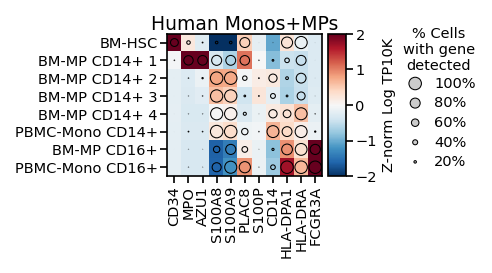

In [369]:
percent_positive = expression.groupby(obs['cluster_clean_full']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(obs['cluster_clean_full']).mean()

width=3.5
heatmap_width=1.5
legend_width=1.5
left_space=.4
dotscale = 6

heatmap_height = .95
bottom_space = .6
top_space = .15
height=heatmap_height+bottom_space+top_space
sizelegendfontsize = 7

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * dotscale) ** 2

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

#heatmap_ax.set_title('B - Seq-Well', pad=0)
        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * dotscale) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .35

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.1, .65, 5)
size_legend_ax.text(0., .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)


sizelegendfontsize = 7
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')

for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.6, 1.05, '% Cells\nwith gene\ndetected', ha='center', va='top', fontsize=sizelegendfontsize)
 
heatmap_ax.set_title('Human Monos+MPs', pad=1)

    
    
    
figure_file = os.path.join(results_dir, "BoneMarrowANDpbmc.Myeloid.10X.MarkerGene.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [61]:
sc.tl.rank_genes_groups(hca_mono_pbmc, groupby='cluster_clean_full')

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


In [62]:
pd.DataFrame(hca_mono_pbmc.uns['rank_genes_groups']['names']).head(20)

BM-HSC BM-MP CD14+ 1 BM-MP CD14+ 2 BM-MP CD14+ 3 BM-MP CD14+ 4  \
0    RPL31        RNASE2        S100A8         S100P        GPR183   
1    RPL34           MPO       S100A12        SEMA3F         THBS1   
2   RPL35A         HMGN2       ALOX5AP          DRC1        LGALS2   
3     RPS6          RETN          RETN       PGLYRP1      HLA-DQB1   
4    EIF3E         MS4A3        S100A9          TFF3        TYROBP   
5     RPL3          AZU1       TMEM107         CNDP1        PFKFB3   
6    RPS18          LSM5        LGALS1           LTF     GABARAPL1   
7    RPS27         HMGN1          CSTA    AC006369.2      C15orf48   
8    RPL15          SRGN            HP        ZSWIM2         CRIP1   
9   RPL13A        SEC61G          QPCT          ORM1        MAP3K8   
10  RPL10A         PLAC8      SERPINB2       CYP19A1         ODF3B   
11    RPL7         RPL35         PROK2       ANXA8L1         CXCL8   
12   RPL12          RPA3         PDE4D         KRT13          SGK1   
13    RPS8         RPLP2         THBS1         IGHGP          FTH1   
14    RPS3        SNHG25          CES1         NR2F1        BCL2A1   
15    RPL5     SERPINB10         CXCL8          LCN6       PHACTR1   
16  RPS15A         PRTN3        RNASE2           PRL         CXCL2   
17   RPS4X         NAA38      IVNS1ABP          LCN2          LY96   
18   RPL26        RNASE3        RNASE1    MIR194-2HG         HBEGF   
19   RPL11       CLEC11A         S100P     LINC00908         PLIN2   

   BM-MP CD16+ PBMC-Mono CD14+ PBMC-Mono CD16+  
0         LST1            CTSS            LST1  
1         FTH1            MNDA           COTL1  
2         RHOC          MT-ND1          FCER1G  
3         AIF1            BRI3            AIF1  
4        TIMP1           GNAI2          FCGR3A  
5         SAT1            CYBB          MT-CO2  
6       FCGR3A           ITGB2         S100A11  
7         CD52             GRN           ARPC3  
8       FCER1G            NCF2           ARPC2  
9       CXCL16           MPEG1            MYL6  
10       DRAP1        SH3BGRL3          MT-CO1  
11       RPS19         S100A11            OAZ1  
12      TMSB4X            VCAN         MT-ATP6  
13      TYROBP          S100A4           PTPRC  
14      NAP1L1           MYO1F           RAP1B  
15       ALDOA            LCP1            SAT1  
16       COTL1          MT-ND3        TNFRSF1B  
17       CD79B            FCN1        SERPINA1  
18         BID            JAML           GNAI2  
19     RNASET2           APLP2             FTL

In [63]:
#pbmc_bm_mono_path = '../../../data/HCA_BoneMarrow/HCA_BM_v2.10X_10KPBMC.Mono.Merged.h5ad'
#pbmc_bm_mono_path = '../../../data/HCA_BoneMarrow/HCA_BM_v2.10X_68KPBMC.Mono.Merged.h5ad'
#pbmc_bm_mono_path = '../../../data/HCA_BoneMarrow/HCA_BM_v2.GSM2895282.Mono.Merged.h5ad'
pbmc_bm_mono_path = '../../../data/HCA_BoneMarrow/HCA_BM_v2.10X_Merge.Mono.Merged.h5ad'


In [64]:
save_adata(hca_mono_pbmc, pbmc_bm_mono_path)

Only considering the two last: ['.Merged', '.h5ad'].
Only considering the two last: ['.Merged', '.h5ad'].


## Project NHP monocytes onto this merged dataset and determine where they land.

In [89]:
adata_ref = sc.AnnData(hca_mono_pbmc.raw.X, obs=hca_mono_pbmc.obs, var=hca_mono_pbmc.raw.var, uns=hca_mono_pbmc.uns)
adata_ref.raw = adata_ref
adata_ref = adata_ref[:, ~adata_ref.var['CellCycle_Genes'] & ~adata_ref.var['ISG']]
adata_ref = adata_ref[adata_ref.obs['cluster_clean']!='BM-HSC',:]
adata_ref = adata_ref.copy()
sc.pp.filter_genes(adata_ref, min_cells=10)
adata_ref.obs['cluster_clean'].value_counts()


filtered out 450 genes that are detectedin less than 10 cells


BM-MP CD14+        50077
PBMC-Mono CD14+    17216
BM-MP CD16+         3924
PBMC-Mono CD16+      982
Name: cluster_clean, dtype: int64

In [90]:
adata_ref.obs['cluster_clean_full'].value_counts()


BM-MP CD14+ 4      18218
PBMC-Mono CD14+    17216
BM-MP CD14+ 3      11944
BM-MP CD14+ 2      11875
BM-MP CD14+ 1       8040
BM-MP CD16+         3924
PBMC-Mono CD16+      982
Name: cluster_clean_full, dtype: int64

In [91]:
adata_ref_orig = adata_ref.copy()

In [92]:
adata_ref.obs['cluster_clean'] = adata_ref.obs['cluster_clean'].astype(str)
adata_ref.obs['cluster_clean_full'] = adata_ref.obs['cluster_clean_full'].astype(str)

In [93]:
adata_ref.obs['cluster_clean_full'].value_counts()


BM-MP CD14+ 4      18218
PBMC-Mono CD14+    17216
BM-MP CD14+ 3      11944
BM-MP CD14+ 2      11875
BM-MP CD14+ 1       8040
BM-MP CD16+         3924
PBMC-Mono CD16+      982
Name: cluster_clean_full, dtype: int64

In [94]:
samplevar = 'cluster_clean_full'

minval = adata_ref.obs[samplevar].value_counts().min()



sample = []
to_downsample = adata_ref.obs[samplevar].unique()
for k in to_downsample:
    g = adata_ref.obs.loc[adata_ref.obs[samplevar]==k,:]
    gsamp = g.sample(minval, replace=False)
    sample += list(gsamp.index)
    
adata_ref_sample = adata_ref[sample, :].copy()
adata_ref_sample.obs[samplevar].value_counts()


BM-MP CD14+ 4      982
BM-MP CD14+ 1      982
PBMC-Mono CD14+    982
BM-MP CD16+        982
BM-MP CD14+ 3      982
BM-MP CD14+ 2      982
PBMC-Mono CD16+    982
Name: cluster_clean_full, dtype: int64

In [150]:
adata_to_use = adata_ref_sample.copy()
adata_for_hvg = adata_ref_sample.copy()

In [151]:
nhpfn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'
adata_query = read_adata(nhpfn, gcs=False)

adata_query = sc.AnnData(X=adata_query.raw.X, obs=adata_query.obs, var=adata_query.raw.var, uns=adata_query.uns)


monocyte_ind = (adata_query.obs['Subclustering_reduced']=='Mono')

adata_query = adata_query[monocyte_ind, :]
sc.pp.filter_genes(adata_query, min_cells=10)
adata_query.raw = adata_query.copy()
#genestokeep = ~(adata_query.var['Combined_Blacklist'] | adata_query.var['CC_Blacklist'])
genestokeep = ~adata_query.var['Combined_Blacklist']
adata_query = adata_query[:, genestokeep]

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].
filtered out 5250 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


In [152]:
adata_query.var['Match_GeneSym'] = adata_query.var['gene_symbol']
ind = ~adata_query.var['gene_symbol'].isin(adata_to_use.var.index) & adata_query.var['human_ortholog_name'].isin(adata_to_use.var.index)
adata_query.var.loc[ind, 'Match_GeneSym'] = adata_query.var.loc[ind, 'human_ortholog_name']
vc = adata_query.var.loc[:, 'Match_GeneSym'].value_counts()
dups = vc.index[vc>1]
genedata = adata_query.var.copy()

Trying to set attribute `.var` of view, copying.


In [153]:
for d in dups:
    inds = genedata.index[genedata['Match_GeneSym']==d]
    matches_genesym = genedata.loc[inds,'gene_symbol'] == genedata.loc[inds,'Match_GeneSym']
    if matches_genesym.sum() == 1:
        todrop = inds[~matches_genesym]
        genedata.loc[todrop,'Match_GeneSym'] = ''
    else:
        sortedvals = genedata.loc[inds,:].sort_values(by=['human_ortholog_percent_confidence', 'human_ortholog_percent_identity'], ascending=False)
        genedata.loc[sortedvals.index[1:],'Match_GeneSym'] = ''

In [154]:
adata_query.var = genedata

In [155]:
adata_query = adata_query[:, adata_query.var['Match_GeneSym']!='']

In [156]:
adata_query.var.index = adata_query.var['Match_GeneSym']

In [157]:
subcluster_info_fn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.MonocyteSubclustering.tsv'
subcluster_info = pd.read_csv(subcluster_info_fn, sep='\t', index_col=0)

In [158]:
hf.classifier_find_shared_genes(adata_to_use, adata_query)
print(adata_to_use.var['valid_for_classification'].sum(), adata_query.var['valid_for_classification'].sum())


Trying to set attribute `.var` of view, copying.


9454 9454


In [159]:
adata_to_use = adata_to_use[:, adata_to_use.var['valid_for_classification']]
adata_for_hvg = adata_for_hvg[:, adata_to_use.var.index]
adata_query = adata_query[:,adata_query.var['valid_for_classification']]
adata_query = adata_query[:, adata_to_use.var.index]

adata_for_hvg.var['valid_for_classification'] = adata_to_use.var['valid_for_classification']

Trying to set attribute `.var` of view, copying.


In [160]:
adata_query

View of AnnData object with n_obs × n_vars = 6976 × 9454 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_B

In [161]:
hf.classifier_learn_pca_projection(adata_to_use, n_pcs=50, find_highvar_genes=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [162]:
hf.classifier_apply_pca_projection(adata_to_use, adata_query)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [163]:
nearest_neighbor_idx = adata_query.obsm['projection_neighbors'][:,0]
subcluster_info['Assigned_Human_Dataset'] = adata_to_use.obs['Dataset'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster'] = adata_to_use.obs['cluster_clean'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster_Full'] = adata_to_use.obs['cluster_clean_full'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster'].value_counts()

PBMC-Mono CD14+    5149
PBMC-Mono CD16+    1066
BM-MP CD14+         706
BM-MP CD16+          55
Name: Assigned_Human_Cluster, dtype: int64

In [164]:
nearest_neighbor_idx = adata_query.obsm['projection_neighbors'][:,0]
subcluster_info['Assigned_Human_Dataset'] = adata_to_use.obs['Dataset'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster'] = adata_to_use.obs['cluster_clean'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster_Full'] = adata_to_use.obs['cluster_clean_full'].values[nearest_neighbor_idx]
subcluster_info['Assigned_Human_Cluster'].value_counts()

PBMC-Mono CD14+    5149
PBMC-Mono CD16+    1066
BM-MP CD14+         706
BM-MP CD16+          55
Name: Assigned_Human_Cluster, dtype: int64

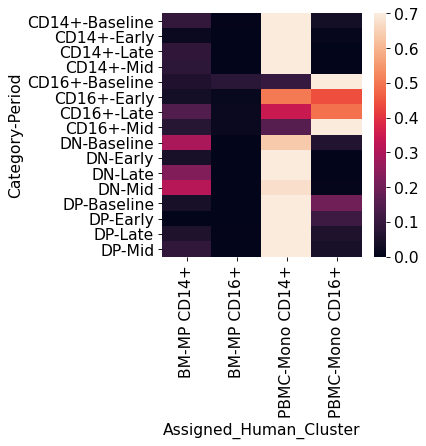

In [165]:
ct = pd.crosstab([subcluster_info['Category'], subcluster_info['Period']], subcluster_info['Assigned_Human_Cluster'])
ctnorm = ct.div(ct.sum(axis=1), axis=0)
sns.heatmap(ctnorm, yticklabels=True, vmax=.7)

In [166]:
ct = pd.crosstab([subcluster_info['Category'], subcluster_info['Period']], subcluster_info['Assigned_Human_Cluster'])
ct

Assigned_Human_Cluster  BM-MP CD14+  BM-MP CD16+  PBMC-Mono CD14+  \
Category Period                                                     
CD14+    Baseline                25            1              232   
         Early                    2            0              112   
         Late                     6            0               62   
         Mid                     14            0              153   
CD16+    Baseline                22           29               38   
         Early                   42           17              555   
         Late                    26            3               62   
         Mid                     14            4               30   
DN       Baseline                14            0               30   
         Early                  104            0             2232   
         Late                   263            0              884   
         Mid                    140            0              301   
DP       Baseline                 2            0               33   
         Early                    0            0               40   
         Late                    13            1              208   
         Mid                     19            0              177   

Assigned_Human_Cluster  PBMC-Mono CD16+  
Category Period                          
CD14+    Baseline                    10  
         Early                        1  
         Late                         0  
         Mid                          0  
CD16+    Baseline                   288  
         Early                      487  
         Late                        88  
         Mid                        143  
DN       Baseline                     3  
         Early                        6  
         Late                         1  
         Mid                          3  
DP       Baseline                     9  
         Early                        5  
         Late                        13  
         Mid                          9

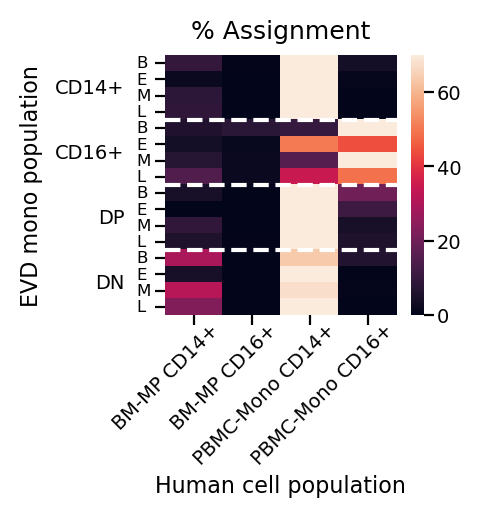

In [257]:
catsub = pd.crosstab([subcluster_info['Category'], subcluster_info['Period']], subcluster_info['Assigned_Human_Cluster'])

period = ['Baseline', 'Early', 'Mid', 'Late']
categories = ['CD14+', 'CD16+', 'DP', 'DN']
order = [(x,y) for x in categories for y in period]
catsub = catsub.loc[order, :]
catsub.index = [x[0] + ' ' + x[1][0] for x in catsub.index]
catsub_norm = catsub.div(catsub.sum(axis=1), axis=0)*100

fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
gs = gridspec.GridSpec(1,1, left=.35, right=.93, bottom=.38, top=.9)
ax = fig.add_subplot(gs[0])

sns.heatmap(catsub_norm, ax=ax, vmin=0, vmax=70)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks(np.arange(catsub_norm.shape[0])+.5)

ax.set_yticklabels([])



for i in range(catsub_norm.shape[0]):
    ax.text(-.5, i+.5, catsub_norm.index[i][-1], fontsize=6, ha='left', va='center')

for (i,y) in enumerate(np.arange(2, catsub_norm.shape[0], 4)):
    ax.text(-.7, y, categories[i], fontsize=7, ha='right', va='center')
    
for y in range(4, catsub_norm.shape[0], 4):
    ax.hlines(y=y, xmin=0, xmax=5, linestyle='--', color='w')
    
    
    
#ax.text(-1.7, (catsub_norm.shape[0]-1)/2, 'NHP cell population', ha='center', va='center', rotation=90, fontsize=9)
ax.set_title('% Assignment', fontsize=9)
ax.set_xticklabels([])




for (i,x) in enumerate([1,2,3,4]):
    ax.text(x, catsub_norm.shape[0]+.3, catsub_norm.columns[i], rotation=45, fontsize=7, va='top', ha='right')

ax.text(2, 26.5, 'Human cell population', va='center', ha='center', fontsize=8)
ax.text(-2.3, 8, 'EVD mono population', va='center', ha='center', fontsize=8, rotation=90)



figure_file = os.path.join(results_dir, "HCA.BoneMarrowPBMC.NHPassignment.Heatmap.pdf")
fig.savefig(figure_file, dpi=200)


In [404]:
catsub_norm

Assigned_Human_Cluster  BM-MP CD14+  BM-MP CD16+  PBMC-Mono CD14+  \
CD14+ B                    9.328358     0.373134        86.567164   
CD14+ E                    1.739130     0.000000        97.391304   
CD14+ M                    8.383234     0.000000        91.616766   
CD14+ L                    8.823529     0.000000        91.176471   
CD16+ B                    5.835544     7.692308        10.079576   
CD16+ E                    3.814714     1.544051        50.408719   
CD16+ M                    7.329843     2.094241        15.706806   
CD16+ L                   14.525140     1.675978        34.636872   
DP B                       4.545455     0.000000        75.000000   
DP E                       0.000000     0.000000        88.888889   
DP M                       9.268293     0.000000        86.341463   
DP L                       5.531915     0.425532        88.510638   
DN B                      29.787234     0.000000        63.829787   
DN E                       4.440649     0.000000        95.303160   
DN M                      31.531532     0.000000        67.792793   
DN L                      22.909408     0.000000        77.003484   

Assigned_Human_Cluster  PBMC-Mono CD16+  
CD14+ B                        3.731343  
CD14+ E                        0.869565  
CD14+ M                        0.000000  
CD14+ L                        0.000000  
CD16+ B                       76.392573  
CD16+ E                       44.232516  
CD16+ M                       74.869110  
CD16+ L                       49.162011  
DP B                          20.454545  
DP E                          11.111111  
DP M                           4.390244  
DP L                           5.531915  
DN B                           6.382979  
DN E                           0.256191  
DN M                           0.675676  
DN L                           0.087108

In [386]:
nhpfn = '../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'
nhp_mono = read_adata(nhpfn)
nhp_mono = sc.AnnData(nhp_mono.raw.X, obs=nhp_mono.obs, var=nhp_mono.raw.var, uns=nhp_mono.uns)

nhp_mono = nhp_mono[nhp_mono.obs['Subclustering_reduced']=='Mono', :]
nhp_mono.raw = nhp_mono.copy()
nhp_mono = nhp_mono[:, ~nhp_mono.var['Combined_Blacklist']]
sc.pp.filter_genes(nhp_mono, min_cells=10)
sc.pp.normalize_per_cell(nhp_mono, counts_per_cell_after=10000)
sc.pp.log1p(nhp_mono)
nhp_mono.obs['Category'] = subcluster_info.loc[nhp_mono.obs.index, 'Category']
nhp_mono = nhp_mono[nhp_mono.obs['Period'].isin(['Baseline', 'Late']),:]


Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].
filtered out 5247 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [387]:
nhp_mono.obs['Category-Period'] = nhp_mono.obs['Category'].astype(str) + '-' + nhp_mono.obs['Period'].astype(str)

Trying to set attribute `.obs` of view, copying.


In [388]:
genes = []
genes_to_plot = ['MPO', 'AZU1', 'S100A8', 'S100A9', 'PLAC8', 'S100P', 'CD14', 'MAMU-DPB', 'MAMU-DRA', 'FCGR3']
expression = pd.DataFrame(nhp_mono[:, genes_to_plot].X.todense(), index=nhp_mono.obs.index, columns=genes_to_plot)
obs = nhp_mono.obs.copy()

celltype_order =[
 'DN-Late',
 'CD14+-Late',
 'DP-Late',
 'CD16+-Late',
 'DN-Baseline',
 'CD14+-Baseline',
'DP-Baseline',
 'CD16+-Baseline']

In [389]:
expression['CD34'] = np.nan
expression = expression.loc[:,['CD34', 'MPO', 'AZU1', 'S100A8', 'S100A9', 'PLAC8', 'S100P', 'CD14', 'MAMU-DPB', 'MAMU-DRA', 'FCGR3']]
genes_to_plot = ['CD34', 'MPO', 'AZU1', 'S100A8', 'S100A9', 'PLAC8', 'S100P', 'CD14', 'MAMU-DPB', 'MAMU-DRA', 'FCGR3']


In [403]:
(nhp_mono.raw[:,'CD34'].X>0).sum()

6

In [ ]:
percent_positive = expression.groupby(obs['Category-Period']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(obs['Category-Period']).mean()

width=3.5
heatmap_width=1.5
legend_width=1.5
left_space=.4
dotscale = 6

heatmap_height = .95
bottom_space = .6
top_space = .15
height=heatmap_height+bottom_space+top_space
sizelegendfontsize = 7

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * dotscale) ** 2

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
import matplotlib
current_cmap = matplotlib.cm.get_cmap("RdBu_r").set_bad(color='.7')




cim= heatmap_ax.imshow(allcolors.loc[celltype_order, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

#heatmap_ax.set_title('B - Seq-Well', pad=0)
        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * dotscale) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .35

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.1, .65, 5)
size_legend_ax.text(0., .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)


sizelegendfontsize = 7
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')

for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.6, 1.05, '% Cells\nwith gene\ndetected', ha='center', va='top', fontsize=sizelegendfontsize)


heatmap_ax.set_title('NHP EVD Monos', pad=1)


figure_file = os.path.join(results_dir, "NHP.MonoSubsets.SeqWell.LateVsBaseline.MarkerGene.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


batch  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged   
...                                                                                               ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged   

                                                    DPI  DPIc    Period  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0     0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0     0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0     0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0     0  Baseline   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...    0     0  Baseline   
...                                                 ...   ...       ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3     3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3     3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3     3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3     3     Early   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...    3     3     Early   

                                                                    full_sample_id  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...   NHP13.D000.fresh.a1.DASH1-std   
...                                                                            ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...  NHP15.D003.fresh.a1.DASH-DASH2   

                                                   frz_status sample_source  \
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merge...      fresh    NHP13.D000   
...                                                       ...           ...   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merg...      fresh    NHP15.D003   
NHP15.D003.fresh.a1.DASH-DASH2_8

filtered out 5247 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


full_id  \
index                                                        
CCNF                              ENSMMUG00000000001__CCNF   
TEDC2                            ENSMMUG00000000002__TEDC2   
NAGA                              ENSMMUG00000000005__NAGA   
BET1                              ENSMMUG00000000007__BET1   
PTPRC                            ENSMMUG00000000009__PTPRC   
...                                                    ...   
ENSMMUG00000049226  ENSMMUG00000049226__ENSMMUG00000049226   
IER5L                            ENSMMUG00000049227__IER5L   
ENSMMUG00000049230  ENSMMUG00000049230__ENSMMUG00000049230   
AMMECR1L                      ENSMMUG00000049232__AMMECR1L   
ZNF736                          ENSMMUG00000049254__ZNF736   

                           gene_symbol             gene_id human_ortholog_id  \
index                                                                          
CCNF                              CCNF  ENSMMUG00000000001   ENSG00000162063   
TEDC2                            TEDC2  ENSMMUG00000000002   ENSG00000162062   
NAGA                              NAGA  ENSMMUG00000000005   ENSG00000198951   
BET1                              BET1  ENSMMUG00000000007   ENSG00000105829   
PTPRC                            PTPRC  ENSMMUG00000000009   ENSG00000081237   
...                                ...                 ...               ...   
ENSMMUG00000049226  ENSMMUG00000049226  ENSMMUG00000049226   ENSG00000163376   
IER5L                            IER5L  ENSMMUG00000049227   ENSG00000188483   
ENSMMUG00000049230  ENSMMUG00000049230  ENSMMUG00000049230               nan   
AMMECR1L                      AMMECR1L  ENSMMUG00000049232   ENSG00000144233   
ZNF736                          ZNF736  ENSMMUG00000049254   ENSG00000234444   

                   human_ortholog_name human_ortholog_type  \
index                                                        
CCNF                              CCNF    ortholog_one2one   
TEDC2                            TEDC2    ortholog_one2one   
NAGA                              NAGA    ortholog_one2one   
BET1                              BET1    ortholog_one2one   
PTPRC                            PTPRC    ortholog_one2one   
...                                ...                 ...   
ENSMMUG00000049226              KBTBD8    ortholog_one2one   
IER5L                            IER5L    ortholog_one2one   
ENSMMUG00000049230                 nan                 nan   
AMMECR1L                      AMMECR1L    ortholog_one2one   
ZNF736                          ZNF736    ortholog_one2one   

                    human_ortholog_percent_identity  \
index                                                 
CCNF                                        97.3282   
TEDC2                                       80.8314   
NAGA                                        97.5669   
BET1                                        95.7627   
PTPRC                                       89.2802   
...                                             ...   
ENSMMUG00000049226                          99.5008   
IER5L                                       98.5149   
ENSMMUG00000049230                              NaN   
AMMECR1L                                    99.6774   
ZNF736                                      93.9110   

                    human_ortholog_percent_confidence       merged_symbol  \
index                                                                       
CCNF                                              1.0                CCNF   
TEDC2                                             1.0               TEDC2   
NAGA                                              1.0                NAGA   
BET1                                              1.0                BET1   
PTPRC                                             1.0               PTPRC   
...                                               ...                 ...   
ENSMMUG00000049226                                1.0           